# Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [2]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

In [3]:
# Imports for evaluation from local lib files
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

# Functions and initiations

## File paths

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [6]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


## Utils

In [7]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [8]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [9]:
# class CustomImageDataset(Dataset):
#     def __init__(self, label_path, img_dir, valid_img, transform = None):
#         self.label_file = json.load(open(label_path))
#         self.img_dir = img_dir
#         self.transform = transform
#         self.valid_img = valid_img

#     def __len__(self):
#         return len(self.valid_img)

#     def __getitem__(self, idx):
        
#         idx = self.valid_img[idx] # consider only images with bbox annotations
#         img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
#         image = read_image(img_path)

#         conv = torchvision.transforms.ToTensor()
#         # if image.shape[0]==1:
#         # some images have only one channel, we convert them to rgb
#         image = Image.open(img_path).convert("RGB")
#         image = conv(image)

#         boxes = [self.label_file['annotations'][j]['bbox'] 
#                  for j in range(len(self.label_file['annotations'])) 
#                  if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
#         label = [self.label_file['annotations'][j]['category_id'] 
#                  for j in range(len(self.label_file['annotations'])) 
#                  if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

#         # transform bbox coords to adjust for resizing
#         scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
#         scale_y = image.shape[1] / self.label_file['images'][idx]['height']

#         boxes = torch.as_tensor(boxes)
#         for i in range(boxes.shape[0]):
#             boxes[i][0] = torch.round(boxes[i][0] * scale_x)
#             boxes[i][1] = torch.round(boxes[i][1] * scale_y)
#             boxes[i][2] = torch.round(boxes[i][2] * scale_x)
#             boxes[i][3] = torch.round(boxes[i][3] * scale_y)

#             boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
#             boxes[i][3] = boxes[i][1] + boxes[i][3]

#         label = torch.as_tensor(label)
#         label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = label
#         target["image_id"] = image_id
#         target['area']=area
#         target['iscrowd']=iscrowd

#         # TO DO : resize all to same size

#         if self.transform:
#             # transform image AND target
#             image, target = self.transform(image, target)

#         return image, target

## Transformation

In [10]:
import transforms as T
import torchvision.transforms as TorchTrans
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

colorTranformations = torch.nn.Sequential(
                      TorchTrans.RandomInvert(0.6),
                      TorchTrans.ColorJitter([.2,.3], [0.8,0.9], [.1,0.12])#jitter2 = T.ColorJitter([.2,.3], [0.7,0.9],  hue=.1)
)

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, rotation = False):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.valid_img = valid_img
        self.rotation = rotation  
        self.rotate= T.RandomHorizontalFlip(0.5)
    
    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd
        # TO DO : resize all to same size
        if self.rotation:
            image, target= self.rotate(image, target)
        if self.transform:
            image = self.transform(image)
        return image, target

## Pre-trained models
Inspred from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with deeper layers to train

In [12]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with even deeper layers to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights

        param.requires_grad = False

    for param in model.roi_heads.parameters():

        param.requires_grad = True

    for param in model.rpn.parameters():

        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Params

In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # our dataset has two classes only - background and person
# num_classes = 2

# # get the model using our helper function
# model = get_model_from_pretrained(num_classes)

# # move model to the right device
# model.to(device)

# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# # like in the paper, construct the scheduler
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

## Mean and Std by chanel by pixel from the training set.  
model.transform.image_mean = [0.3321, 0.3406, 0.3210] # mean = [0.3321, 0.3406, 0.3210]
model.transform.image_std = [0.2359, 0.2369, 0.2313] # std = [0.2359, 0.2369, 0.2313]

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

## OPTIONAL - Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/25_roi_1_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/25_roi_1_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/25_roi_1_scheduler.pt'))

## Create the dataloaders
To load the data of the dataset efficiently for the model

In [14]:
def create_dataloader(ann_path, batch_size, shuffle=True, transform=None, rotation=False):
    images_with_bbox,_ = get_img_with_bbox(ann_path)
    data = CustomImageDataset(ann_path, img_folder, images_with_bbox, transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=utils.collate_fn)

#### You can specify the data augmentation transformation at will

In [15]:
train_dataloader = create_dataloader(train_ann_path, 1, transform=colorTranformations, rotation=True)
cis_valid_dataloader = create_dataloader(cis_val_ann_path, 10)
trans_valid_dataloader = create_dataloader(trans_val_ann_path, 10)
cis_test_dataloader = create_dataloader(cis_test_ann_path, 10)
trans_test_dataloader = create_dataloader(trans_test_ann_path, 10)

## Define the 'evaluate' fonction

In [16]:
# Loads the test datasetfor coco evaluation
cis_coco = get_coco_api_from_dataset(cis_test_dataloader.dataset)
trans_coco = get_coco_api_from_dataset(trans_test_dataloader.dataset)

creating index...
index created!
creating index...
index created!


In [17]:
# TODO: méthode pour évaluer 
def evaluate(dataloader, coco, nms=True, iou=0.35):
    apply_nms = nms
    iou_threshold = iou # param to potentially tune (threshold for nms)
    the_data_loader = dataloader # change to test set
    
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    model.eval()

    for images, targets in the_data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():

            pred=model(images)

            if apply_nms:
                boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
                pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
                pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
                pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

            outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
    
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

## Logs utils

#### Train logs utils

In [18]:
import time

In [19]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values


# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst


# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

In [20]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [21]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [22]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [23]:
# Converts the valid logs from list of dictionnaries to string
# TODO: add if type == list to not do anything if its already a list
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [24]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [25]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

# Training the model

In [26]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    model.train()
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')
    
    
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


# Interactive Part

### Before training

In [27]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

### This next cell starts the training of the model

In [28]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 10:41:12  lr: 0.000001  loss: 0.9138 (0.9138)  loss_classifier: 0.6629 (0.6629)  loss_box_reg: 0.2153 (0.2153)  loss_objectness: 0.0338 (0.0338)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 3.1798  data: 0.0670  max mem: 524
Epoch: [0]  [  100/12099]  eta: 0:33:45  lr: 0.000031  loss: 0.2969 (0.5204)  loss_classifier: 0.1243 (0.3385)  loss_box_reg: 0.1062 (0.0944)  loss_objectness: 0.0834 (0.0768)  loss_rpn_box_reg: 0.0042 (0.0106)  time: 0.1402  data: 0.0565  max mem: 630
Epoch: [0]  [  200/12099]  eta: 0:31:12  lr: 0.000061  loss: 0.2585 (0.3992)  loss_classifier: 0.1039 (0.2137)  loss_box_reg: 0.1099 (0.0874)  loss_objectness: 0.0267 (0.0887)  loss_rpn_box_reg: 0.0048 (0.0094)  time: 0.1430  data: 0.0572  max mem: 630
Epoch: [0]  [  300/12099]  eta: 0:29:50  lr: 0.000091  loss: 0.2610 (0.3526)  loss_classifier: 0.0838 (0.1685)  loss_box_reg: 0.0903 (0.0861)  loss_objectness: 0.0668 (0.0883)  loss_rpn_box_reg: 0.0044 (0.0097)  time: 0.1397  data: 0.0561  

Epoch: [0]  [ 3300/12099]  eta: 0:20:30  lr: 0.000300  loss: 0.1617 (0.2289)  loss_classifier: 0.0363 (0.0649)  loss_box_reg: 0.0464 (0.0618)  loss_objectness: 0.0502 (0.0921)  loss_rpn_box_reg: 0.0049 (0.0101)  time: 0.1370  data: 0.0544  max mem: 630
Epoch: [0]  [ 3400/12099]  eta: 0:20:15  lr: 0.000300  loss: 0.1753 (0.2279)  loss_classifier: 0.0344 (0.0643)  loss_box_reg: 0.0277 (0.0614)  loss_objectness: 0.1110 (0.0920)  loss_rpn_box_reg: 0.0040 (0.0101)  time: 0.1373  data: 0.0544  max mem: 630
Epoch: [0]  [ 3500/12099]  eta: 0:20:00  lr: 0.000300  loss: 0.1692 (0.2274)  loss_classifier: 0.0432 (0.0639)  loss_box_reg: 0.0468 (0.0610)  loss_objectness: 0.0529 (0.0923)  loss_rpn_box_reg: 0.0058 (0.0102)  time: 0.1362  data: 0.0535  max mem: 630
Epoch: [0]  [ 3600/12099]  eta: 0:19:46  lr: 0.000300  loss: 0.1773 (0.2262)  loss_classifier: 0.0468 (0.0634)  loss_box_reg: 0.0344 (0.0606)  loss_objectness: 0.0840 (0.0921)  loss_rpn_box_reg: 0.0037 (0.0101)  time: 0.1373  data: 0.0542  m

Epoch: [0]  [ 6600/12099]  eta: 0:12:43  lr: 0.000300  loss: 0.1420 (0.2114)  loss_classifier: 0.0321 (0.0545)  loss_box_reg: 0.0406 (0.0543)  loss_objectness: 0.0432 (0.0924)  loss_rpn_box_reg: 0.0036 (0.0103)  time: 0.1381  data: 0.0545  max mem: 630
Epoch: [0]  [ 6700/12099]  eta: 0:12:29  lr: 0.000300  loss: 0.1757 (0.2112)  loss_classifier: 0.0454 (0.0544)  loss_box_reg: 0.0490 (0.0542)  loss_objectness: 0.0779 (0.0924)  loss_rpn_box_reg: 0.0051 (0.0103)  time: 0.1381  data: 0.0551  max mem: 630
Epoch: [0]  [ 6800/12099]  eta: 0:12:15  lr: 0.000300  loss: 0.1383 (0.2106)  loss_classifier: 0.0259 (0.0542)  loss_box_reg: 0.0314 (0.0541)  loss_objectness: 0.0639 (0.0921)  loss_rpn_box_reg: 0.0046 (0.0102)  time: 0.1366  data: 0.0538  max mem: 630
Epoch: [0]  [ 6900/12099]  eta: 0:12:01  lr: 0.000300  loss: 0.1753 (0.2102)  loss_classifier: 0.0414 (0.0540)  loss_box_reg: 0.0416 (0.0540)  loss_objectness: 0.0481 (0.0920)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1383  data: 0.0558  m

Epoch: [0]  [ 9900/12099]  eta: 0:05:04  lr: 0.000300  loss: 0.1833 (0.2036)  loss_classifier: 0.0299 (0.0499)  loss_box_reg: 0.0246 (0.0513)  loss_objectness: 0.0645 (0.0921)  loss_rpn_box_reg: 0.0049 (0.0103)  time: 0.1383  data: 0.0552  max mem: 630
Epoch: [0]  [10000/12099]  eta: 0:04:50  lr: 0.000300  loss: 0.2015 (0.2035)  loss_classifier: 0.0372 (0.0499)  loss_box_reg: 0.0438 (0.0512)  loss_objectness: 0.0889 (0.0921)  loss_rpn_box_reg: 0.0039 (0.0103)  time: 0.1360  data: 0.0538  max mem: 630
Epoch: [0]  [10100/12099]  eta: 0:04:36  lr: 0.000300  loss: 0.1278 (0.2033)  loss_classifier: 0.0297 (0.0498)  loss_box_reg: 0.0351 (0.0512)  loss_objectness: 0.0558 (0.0921)  loss_rpn_box_reg: 0.0036 (0.0103)  time: 0.1365  data: 0.0533  max mem: 630
Epoch: [0]  [10200/12099]  eta: 0:04:23  lr: 0.000300  loss: 0.1811 (0.2032)  loss_classifier: 0.0277 (0.0496)  loss_box_reg: 0.0408 (0.0511)  loss_objectness: 0.1089 (0.0922)  loss_rpn_box_reg: 0.0067 (0.0103)  time: 0.1373  data: 0.0547  m

Epoch: [1]  [ 1000/12099]  eta: 0:25:59  lr: 0.000300  loss: 0.1565 (0.1781)  loss_classifier: 0.0231 (0.0374)  loss_box_reg: 0.0171 (0.0439)  loss_objectness: 0.1102 (0.0870)  loss_rpn_box_reg: 0.0067 (0.0098)  time: 0.1400  data: 0.0561  max mem: 3859
Epoch: [1]  [ 1100/12099]  eta: 0:25:44  lr: 0.000300  loss: 0.1673 (0.1777)  loss_classifier: 0.0269 (0.0376)  loss_box_reg: 0.0291 (0.0444)  loss_objectness: 0.0682 (0.0859)  loss_rpn_box_reg: 0.0078 (0.0098)  time: 0.1414  data: 0.0581  max mem: 3859
Epoch: [1]  [ 1200/12099]  eta: 0:25:29  lr: 0.000300  loss: 0.1554 (0.1777)  loss_classifier: 0.0194 (0.0372)  loss_box_reg: 0.0223 (0.0438)  loss_objectness: 0.0800 (0.0868)  loss_rpn_box_reg: 0.0058 (0.0099)  time: 0.1397  data: 0.0563  max mem: 3859
Epoch: [1]  [ 1300/12099]  eta: 0:25:15  lr: 0.000300  loss: 0.1384 (0.1772)  loss_classifier: 0.0256 (0.0369)  loss_box_reg: 0.0295 (0.0433)  loss_objectness: 0.0475 (0.0871)  loss_rpn_box_reg: 0.0023 (0.0099)  time: 0.1398  data: 0.0555

Epoch: [1]  [ 4300/12099]  eta: 0:18:10  lr: 0.000300  loss: 0.1067 (0.1825)  loss_classifier: 0.0289 (0.0367)  loss_box_reg: 0.0428 (0.0432)  loss_objectness: 0.0307 (0.0923)  loss_rpn_box_reg: 0.0052 (0.0103)  time: 0.1383  data: 0.0549  max mem: 3859
Epoch: [1]  [ 4400/12099]  eta: 0:17:56  lr: 0.000300  loss: 0.1242 (0.1823)  loss_classifier: 0.0219 (0.0367)  loss_box_reg: 0.0398 (0.0431)  loss_objectness: 0.0354 (0.0922)  loss_rpn_box_reg: 0.0045 (0.0103)  time: 0.1400  data: 0.0569  max mem: 3859
Epoch: [1]  [ 4500/12099]  eta: 0:17:43  lr: 0.000300  loss: 0.1129 (0.1824)  loss_classifier: 0.0323 (0.0367)  loss_box_reg: 0.0272 (0.0431)  loss_objectness: 0.0156 (0.0922)  loss_rpn_box_reg: 0.0033 (0.0104)  time: 0.1410  data: 0.0572  max mem: 3859
Epoch: [1]  [ 4600/12099]  eta: 0:17:29  lr: 0.000300  loss: 0.1720 (0.1824)  loss_classifier: 0.0284 (0.0367)  loss_box_reg: 0.0301 (0.0430)  loss_objectness: 0.0756 (0.0924)  loss_rpn_box_reg: 0.0061 (0.0104)  time: 0.1409  data: 0.0581

Epoch: [1]  [ 7600/12099]  eta: 0:10:28  lr: 0.000300  loss: 0.1274 (0.1820)  loss_classifier: 0.0290 (0.0362)  loss_box_reg: 0.0490 (0.0426)  loss_objectness: 0.0155 (0.0926)  loss_rpn_box_reg: 0.0031 (0.0105)  time: 0.1390  data: 0.0555  max mem: 3859
Epoch: [1]  [ 7700/12099]  eta: 0:10:14  lr: 0.000300  loss: 0.1507 (0.1819)  loss_classifier: 0.0182 (0.0362)  loss_box_reg: 0.0311 (0.0425)  loss_objectness: 0.0877 (0.0927)  loss_rpn_box_reg: 0.0037 (0.0105)  time: 0.1398  data: 0.0567  max mem: 3859
Epoch: [1]  [ 7800/12099]  eta: 0:10:00  lr: 0.000300  loss: 0.1546 (0.1820)  loss_classifier: 0.0304 (0.0362)  loss_box_reg: 0.0339 (0.0425)  loss_objectness: 0.0409 (0.0927)  loss_rpn_box_reg: 0.0073 (0.0105)  time: 0.1451  data: 0.0602  max mem: 3859
Epoch: [1]  [ 7900/12099]  eta: 0:09:47  lr: 0.000300  loss: 0.1267 (0.1820)  loss_classifier: 0.0280 (0.0363)  loss_box_reg: 0.0388 (0.0426)  loss_objectness: 0.0270 (0.0926)  loss_rpn_box_reg: 0.0040 (0.0105)  time: 0.1446  data: 0.0597

Epoch: [1]  [10900/12099]  eta: 0:02:47  lr: 0.000300  loss: 0.1790 (0.1803)  loss_classifier: 0.0329 (0.0358)  loss_box_reg: 0.0515 (0.0423)  loss_objectness: 0.0852 (0.0919)  loss_rpn_box_reg: 0.0051 (0.0103)  time: 0.1388  data: 0.0555  max mem: 3859
Epoch: [1]  [11000/12099]  eta: 0:02:33  lr: 0.000300  loss: 0.1464 (0.1803)  loss_classifier: 0.0199 (0.0358)  loss_box_reg: 0.0328 (0.0423)  loss_objectness: 0.0717 (0.0920)  loss_rpn_box_reg: 0.0046 (0.0103)  time: 0.1409  data: 0.0577  max mem: 3859
Epoch: [1]  [11100/12099]  eta: 0:02:19  lr: 0.000300  loss: 0.1281 (0.1801)  loss_classifier: 0.0253 (0.0358)  loss_box_reg: 0.0328 (0.0424)  loss_objectness: 0.0549 (0.0917)  loss_rpn_box_reg: 0.0026 (0.0103)  time: 0.1408  data: 0.0575  max mem: 3859
Epoch: [1]  [11200/12099]  eta: 0:02:05  lr: 0.000300  loss: 0.1241 (0.1799)  loss_classifier: 0.0196 (0.0357)  loss_box_reg: 0.0215 (0.0423)  loss_objectness: 0.0511 (0.0916)  loss_rpn_box_reg: 0.0042 (0.0102)  time: 0.1402  data: 0.0563

Epoch: [2]  [ 2000/12099]  eta: 0:23:25  lr: 0.000300  loss: 0.1261 (0.1780)  loss_classifier: 0.0316 (0.0339)  loss_box_reg: 0.0300 (0.0411)  loss_objectness: 0.0861 (0.0928)  loss_rpn_box_reg: 0.0046 (0.0102)  time: 0.1386  data: 0.0549  max mem: 3859
Epoch: [2]  [ 2100/12099]  eta: 0:23:11  lr: 0.000300  loss: 0.1460 (0.1792)  loss_classifier: 0.0207 (0.0341)  loss_box_reg: 0.0342 (0.0411)  loss_objectness: 0.0540 (0.0938)  loss_rpn_box_reg: 0.0075 (0.0102)  time: 0.1380  data: 0.0549  max mem: 3859
Epoch: [2]  [ 2200/12099]  eta: 0:22:56  lr: 0.000300  loss: 0.1257 (0.1797)  loss_classifier: 0.0293 (0.0341)  loss_box_reg: 0.0350 (0.0412)  loss_objectness: 0.0430 (0.0941)  loss_rpn_box_reg: 0.0044 (0.0104)  time: 0.1374  data: 0.0545  max mem: 3859
Epoch: [2]  [ 2300/12099]  eta: 0:22:43  lr: 0.000300  loss: 0.1334 (0.1804)  loss_classifier: 0.0254 (0.0341)  loss_box_reg: 0.0409 (0.0412)  loss_objectness: 0.0411 (0.0947)  loss_rpn_box_reg: 0.0055 (0.0104)  time: 0.1404  data: 0.0564

Epoch: [2]  [ 5300/12099]  eta: 0:15:46  lr: 0.000300  loss: 0.1334 (0.1785)  loss_classifier: 0.0300 (0.0333)  loss_box_reg: 0.0346 (0.0408)  loss_objectness: 0.0370 (0.0939)  loss_rpn_box_reg: 0.0042 (0.0105)  time: 0.1405  data: 0.0566  max mem: 3859
Epoch: [2]  [ 5400/12099]  eta: 0:15:32  lr: 0.000300  loss: 0.1630 (0.1782)  loss_classifier: 0.0287 (0.0333)  loss_box_reg: 0.0369 (0.0408)  loss_objectness: 0.0927 (0.0937)  loss_rpn_box_reg: 0.0051 (0.0104)  time: 0.1387  data: 0.0560  max mem: 3859
Epoch: [2]  [ 5500/12099]  eta: 0:15:18  lr: 0.000300  loss: 0.1440 (0.1780)  loss_classifier: 0.0296 (0.0333)  loss_box_reg: 0.0317 (0.0407)  loss_objectness: 0.0799 (0.0936)  loss_rpn_box_reg: 0.0048 (0.0104)  time: 0.1411  data: 0.0569  max mem: 3859
Epoch: [2]  [ 5600/12099]  eta: 0:15:04  lr: 0.000300  loss: 0.1466 (0.1780)  loss_classifier: 0.0211 (0.0333)  loss_box_reg: 0.0473 (0.0408)  loss_objectness: 0.0365 (0.0936)  loss_rpn_box_reg: 0.0043 (0.0103)  time: 0.1393  data: 0.0552

Epoch: [2]  [ 8600/12099]  eta: 0:08:07  lr: 0.000300  loss: 0.1460 (0.1758)  loss_classifier: 0.0262 (0.0331)  loss_box_reg: 0.0404 (0.0407)  loss_objectness: 0.0650 (0.0918)  loss_rpn_box_reg: 0.0038 (0.0102)  time: 0.1412  data: 0.0573  max mem: 3859
Epoch: [2]  [ 8700/12099]  eta: 0:07:53  lr: 0.000300  loss: 0.1193 (0.1757)  loss_classifier: 0.0252 (0.0331)  loss_box_reg: 0.0448 (0.0406)  loss_objectness: 0.0234 (0.0919)  loss_rpn_box_reg: 0.0038 (0.0102)  time: 0.1414  data: 0.0576  max mem: 3859
Epoch: [2]  [ 8800/12099]  eta: 0:07:39  lr: 0.000300  loss: 0.1609 (0.1756)  loss_classifier: 0.0290 (0.0331)  loss_box_reg: 0.0303 (0.0406)  loss_objectness: 0.0200 (0.0918)  loss_rpn_box_reg: 0.0053 (0.0102)  time: 0.1388  data: 0.0553  max mem: 3859
Epoch: [2]  [ 8900/12099]  eta: 0:07:25  lr: 0.000300  loss: 0.1345 (0.1756)  loss_classifier: 0.0329 (0.0331)  loss_box_reg: 0.0415 (0.0406)  loss_objectness: 0.0432 (0.0918)  loss_rpn_box_reg: 0.0056 (0.0101)  time: 0.1397  data: 0.0559

Epoch: [2]  [11900/12099]  eta: 0:00:27  lr: 0.000300  loss: 0.1190 (0.1754)  loss_classifier: 0.0337 (0.0330)  loss_box_reg: 0.0359 (0.0407)  loss_objectness: 0.0472 (0.0914)  loss_rpn_box_reg: 0.0036 (0.0103)  time: 0.1385  data: 0.0546  max mem: 3859
Epoch: [2]  [12000/12099]  eta: 0:00:13  lr: 0.000300  loss: 0.1194 (0.1752)  loss_classifier: 0.0271 (0.0330)  loss_box_reg: 0.0438 (0.0407)  loss_objectness: 0.0248 (0.0913)  loss_rpn_box_reg: 0.0033 (0.0103)  time: 0.1398  data: 0.0556  max mem: 3859
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.1310 (0.1752)  loss_classifier: 0.0263 (0.0329)  loss_box_reg: 0.0437 (0.0406)  loss_objectness: 0.0508 (0.0913)  loss_rpn_box_reg: 0.0047 (0.0103)  time: 0.1379  data: 0.0540  max mem: 3859
Epoch: [2] Total time: 0:28:04 (0.1392 s / it)
Epoch: [3]  [    0/12099]  eta: 0:28:07  lr: 0.000300  loss: 0.3010 (0.3010)  loss_classifier: 0.0236 (0.0236)  loss_box_reg: 0.0185 (0.0185)  loss_objectness: 0.2542 (0.2542)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:21:03  lr: 0.000300  loss: 0.1854 (0.1748)  loss_classifier: 0.0295 (0.0321)  loss_box_reg: 0.0351 (0.0410)  loss_objectness: 0.0708 (0.0917)  loss_rpn_box_reg: 0.0040 (0.0101)  time: 0.1401  data: 0.0568  max mem: 3859
Epoch: [3]  [ 3100/12099]  eta: 0:20:49  lr: 0.000300  loss: 0.1395 (0.1753)  loss_classifier: 0.0188 (0.0321)  loss_box_reg: 0.0295 (0.0408)  loss_objectness: 0.0310 (0.0923)  loss_rpn_box_reg: 0.0040 (0.0101)  time: 0.1394  data: 0.0555  max mem: 3859
Epoch: [3]  [ 3200/12099]  eta: 0:20:35  lr: 0.000300  loss: 0.1069 (0.1755)  loss_classifier: 0.0150 (0.0321)  loss_box_reg: 0.0275 (0.0407)  loss_objectness: 0.0388 (0.0927)  loss_rpn_box_reg: 0.0029 (0.0101)  time: 0.1382  data: 0.0547  max mem: 3859
Epoch: [3]  [ 3300/12099]  eta: 0:20:21  lr: 0.000300  loss: 0.1160 (0.1754)  loss_classifier: 0.0399 (0.0321)  loss_box_reg: 0.0492 (0.0407)  loss_objectness: 0.0118 (0.0925)  loss_rpn_box_reg: 0.0024 (0.0101)  time: 0.1375  data: 0.0545

Epoch: [3]  [ 6300/12099]  eta: 0:13:26  lr: 0.000300  loss: 0.1191 (0.1726)  loss_classifier: 0.0194 (0.0311)  loss_box_reg: 0.0209 (0.0396)  loss_objectness: 0.0271 (0.0916)  loss_rpn_box_reg: 0.0062 (0.0104)  time: 0.1384  data: 0.0558  max mem: 3859
Epoch: [3]  [ 6400/12099]  eta: 0:13:12  lr: 0.000300  loss: 0.1479 (0.1727)  loss_classifier: 0.0216 (0.0311)  loss_box_reg: 0.0369 (0.0395)  loss_objectness: 0.0498 (0.0916)  loss_rpn_box_reg: 0.0047 (0.0104)  time: 0.1399  data: 0.0557  max mem: 3859
Epoch: [3]  [ 6500/12099]  eta: 0:12:58  lr: 0.000300  loss: 0.1356 (0.1729)  loss_classifier: 0.0219 (0.0310)  loss_box_reg: 0.0244 (0.0395)  loss_objectness: 0.0442 (0.0919)  loss_rpn_box_reg: 0.0065 (0.0104)  time: 0.1387  data: 0.0551  max mem: 3859
Epoch: [3]  [ 6600/12099]  eta: 0:12:44  lr: 0.000300  loss: 0.1548 (0.1730)  loss_classifier: 0.0289 (0.0310)  loss_box_reg: 0.0435 (0.0395)  loss_objectness: 0.0583 (0.0921)  loss_rpn_box_reg: 0.0037 (0.0104)  time: 0.1356  data: 0.0527

Epoch: [3]  [ 9600/12099]  eta: 0:05:47  lr: 0.000300  loss: 0.1285 (0.1738)  loss_classifier: 0.0252 (0.0311)  loss_box_reg: 0.0344 (0.0395)  loss_objectness: 0.0441 (0.0928)  loss_rpn_box_reg: 0.0031 (0.0103)  time: 0.1374  data: 0.0544  max mem: 3859
Epoch: [3]  [ 9700/12099]  eta: 0:05:33  lr: 0.000300  loss: 0.1225 (0.1738)  loss_classifier: 0.0154 (0.0311)  loss_box_reg: 0.0124 (0.0395)  loss_objectness: 0.0417 (0.0928)  loss_rpn_box_reg: 0.0040 (0.0103)  time: 0.1407  data: 0.0565  max mem: 3859
Epoch: [3]  [ 9800/12099]  eta: 0:05:19  lr: 0.000300  loss: 0.1220 (0.1737)  loss_classifier: 0.0149 (0.0311)  loss_box_reg: 0.0283 (0.0395)  loss_objectness: 0.0625 (0.0928)  loss_rpn_box_reg: 0.0049 (0.0103)  time: 0.1398  data: 0.0569  max mem: 3859
Epoch: [3]  [ 9900/12099]  eta: 0:05:05  lr: 0.000300  loss: 0.1375 (0.1736)  loss_classifier: 0.0204 (0.0310)  loss_box_reg: 0.0217 (0.0395)  loss_objectness: 0.0701 (0.0927)  loss_rpn_box_reg: 0.0048 (0.0104)  time: 0.1399  data: 0.0560

Epoch: [4]  [  700/12099]  eta: 0:26:45  lr: 0.000300  loss: 0.1143 (0.1698)  loss_classifier: 0.0257 (0.0288)  loss_box_reg: 0.0286 (0.0377)  loss_objectness: 0.0390 (0.0935)  loss_rpn_box_reg: 0.0060 (0.0099)  time: 0.1376  data: 0.0539  max mem: 3859
Epoch: [4]  [  800/12099]  eta: 0:26:30  lr: 0.000300  loss: 0.1488 (0.1718)  loss_classifier: 0.0264 (0.0291)  loss_box_reg: 0.0318 (0.0381)  loss_objectness: 0.0390 (0.0947)  loss_rpn_box_reg: 0.0027 (0.0100)  time: 0.1390  data: 0.0555  max mem: 3859
Epoch: [4]  [  900/12099]  eta: 0:26:14  lr: 0.000300  loss: 0.1427 (0.1728)  loss_classifier: 0.0218 (0.0296)  loss_box_reg: 0.0346 (0.0383)  loss_objectness: 0.0604 (0.0949)  loss_rpn_box_reg: 0.0038 (0.0099)  time: 0.1389  data: 0.0550  max mem: 3859
Epoch: [4]  [ 1000/12099]  eta: 0:25:58  lr: 0.000300  loss: 0.1334 (0.1718)  loss_classifier: 0.0178 (0.0295)  loss_box_reg: 0.0289 (0.0380)  loss_objectness: 0.0659 (0.0942)  loss_rpn_box_reg: 0.0070 (0.0101)  time: 0.1414  data: 0.0571

Epoch: [4]  [ 4000/12099]  eta: 0:18:55  lr: 0.000300  loss: 0.1538 (0.1706)  loss_classifier: 0.0187 (0.0294)  loss_box_reg: 0.0317 (0.0388)  loss_objectness: 0.0568 (0.0924)  loss_rpn_box_reg: 0.0062 (0.0099)  time: 0.1414  data: 0.0571  max mem: 3859
Epoch: [4]  [ 4100/12099]  eta: 0:18:41  lr: 0.000300  loss: 0.1384 (0.1705)  loss_classifier: 0.0176 (0.0294)  loss_box_reg: 0.0269 (0.0388)  loss_objectness: 0.0853 (0.0924)  loss_rpn_box_reg: 0.0050 (0.0099)  time: 0.1392  data: 0.0556  max mem: 3859
Epoch: [4]  [ 4200/12099]  eta: 0:18:28  lr: 0.000300  loss: 0.1149 (0.1703)  loss_classifier: 0.0270 (0.0295)  loss_box_reg: 0.0411 (0.0389)  loss_objectness: 0.0364 (0.0920)  loss_rpn_box_reg: 0.0052 (0.0098)  time: 0.1405  data: 0.0570  max mem: 3859
Epoch: [4]  [ 4300/12099]  eta: 0:18:15  lr: 0.000300  loss: 0.1217 (0.1698)  loss_classifier: 0.0253 (0.0295)  loss_box_reg: 0.0377 (0.0389)  loss_objectness: 0.0313 (0.0916)  loss_rpn_box_reg: 0.0050 (0.0098)  time: 0.1393  data: 0.0562

Epoch: [4]  [ 7300/12099]  eta: 0:11:13  lr: 0.000300  loss: 0.1087 (0.1704)  loss_classifier: 0.0208 (0.0297)  loss_box_reg: 0.0341 (0.0388)  loss_objectness: 0.0361 (0.0917)  loss_rpn_box_reg: 0.0028 (0.0102)  time: 0.1398  data: 0.0557  max mem: 3859
Epoch: [4]  [ 7400/12099]  eta: 0:10:59  lr: 0.000300  loss: 0.1754 (0.1704)  loss_classifier: 0.0217 (0.0297)  loss_box_reg: 0.0254 (0.0388)  loss_objectness: 0.1149 (0.0916)  loss_rpn_box_reg: 0.0027 (0.0102)  time: 0.1406  data: 0.0570  max mem: 3859
Epoch: [4]  [ 7500/12099]  eta: 0:10:45  lr: 0.000300  loss: 0.1168 (0.1703)  loss_classifier: 0.0160 (0.0296)  loss_box_reg: 0.0239 (0.0387)  loss_objectness: 0.0726 (0.0917)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1393  data: 0.0558  max mem: 3859
Epoch: [4]  [ 7600/12099]  eta: 0:10:31  lr: 0.000300  loss: 0.1493 (0.1702)  loss_classifier: 0.0183 (0.0296)  loss_box_reg: 0.0227 (0.0387)  loss_objectness: 0.0500 (0.0916)  loss_rpn_box_reg: 0.0063 (0.0102)  time: 0.1430  data: 0.0580

Epoch: [4]  [10600/12099]  eta: 0:03:30  lr: 0.000300  loss: 0.1177 (0.1703)  loss_classifier: 0.0161 (0.0296)  loss_box_reg: 0.0239 (0.0388)  loss_objectness: 0.0419 (0.0916)  loss_rpn_box_reg: 0.0046 (0.0103)  time: 0.1375  data: 0.0539  max mem: 3859
Epoch: [4]  [10700/12099]  eta: 0:03:16  lr: 0.000300  loss: 0.1718 (0.1705)  loss_classifier: 0.0205 (0.0296)  loss_box_reg: 0.0305 (0.0388)  loss_objectness: 0.0797 (0.0917)  loss_rpn_box_reg: 0.0077 (0.0103)  time: 0.1373  data: 0.0539  max mem: 3859
Epoch: [4]  [10800/12099]  eta: 0:03:02  lr: 0.000300  loss: 0.1483 (0.1706)  loss_classifier: 0.0171 (0.0296)  loss_box_reg: 0.0262 (0.0388)  loss_objectness: 0.0659 (0.0918)  loss_rpn_box_reg: 0.0050 (0.0103)  time: 0.1392  data: 0.0563  max mem: 3859
Epoch: [4]  [10900/12099]  eta: 0:02:48  lr: 0.000300  loss: 0.1978 (0.1706)  loss_classifier: 0.0231 (0.0296)  loss_box_reg: 0.0318 (0.0388)  loss_objectness: 0.0969 (0.0919)  loss_rpn_box_reg: 0.0048 (0.0103)  time: 0.1390  data: 0.0556

Epoch: [5]  [ 1700/12099]  eta: 0:24:07  lr: 0.000030  loss: 0.1696 (0.1713)  loss_classifier: 0.0174 (0.0290)  loss_box_reg: 0.0290 (0.0381)  loss_objectness: 0.0850 (0.0939)  loss_rpn_box_reg: 0.0038 (0.0103)  time: 0.1396  data: 0.0563  max mem: 3859
Epoch: [5]  [ 1800/12099]  eta: 0:23:53  lr: 0.000030  loss: 0.1069 (0.1706)  loss_classifier: 0.0215 (0.0289)  loss_box_reg: 0.0280 (0.0379)  loss_objectness: 0.0520 (0.0935)  loss_rpn_box_reg: 0.0032 (0.0103)  time: 0.1371  data: 0.0544  max mem: 3859
Epoch: [5]  [ 1900/12099]  eta: 0:23:39  lr: 0.000030  loss: 0.1643 (0.1698)  loss_classifier: 0.0223 (0.0289)  loss_box_reg: 0.0407 (0.0380)  loss_objectness: 0.0339 (0.0925)  loss_rpn_box_reg: 0.0045 (0.0103)  time: 0.1398  data: 0.0561  max mem: 3859
Epoch: [5]  [ 2000/12099]  eta: 0:23:24  lr: 0.000030  loss: 0.0987 (0.1691)  loss_classifier: 0.0199 (0.0290)  loss_box_reg: 0.0267 (0.0381)  loss_objectness: 0.0169 (0.0918)  loss_rpn_box_reg: 0.0033 (0.0102)  time: 0.1371  data: 0.0538

Epoch: [5]  [ 5000/12099]  eta: 0:16:27  lr: 0.000030  loss: 0.1073 (0.1678)  loss_classifier: 0.0169 (0.0287)  loss_box_reg: 0.0271 (0.0379)  loss_objectness: 0.0300 (0.0911)  loss_rpn_box_reg: 0.0030 (0.0101)  time: 0.1391  data: 0.0552  max mem: 3859
Epoch: [5]  [ 5100/12099]  eta: 0:16:13  lr: 0.000030  loss: 0.1093 (0.1676)  loss_classifier: 0.0242 (0.0286)  loss_box_reg: 0.0302 (0.0379)  loss_objectness: 0.0212 (0.0909)  loss_rpn_box_reg: 0.0041 (0.0102)  time: 0.1407  data: 0.0569  max mem: 3859
Epoch: [5]  [ 5200/12099]  eta: 0:15:59  lr: 0.000030  loss: 0.1056 (0.1676)  loss_classifier: 0.0230 (0.0285)  loss_box_reg: 0.0372 (0.0378)  loss_objectness: 0.0321 (0.0911)  loss_rpn_box_reg: 0.0045 (0.0102)  time: 0.1376  data: 0.0540  max mem: 3859
Epoch: [5]  [ 5300/12099]  eta: 0:15:45  lr: 0.000030  loss: 0.1305 (0.1678)  loss_classifier: 0.0156 (0.0285)  loss_box_reg: 0.0193 (0.0377)  loss_objectness: 0.0423 (0.0914)  loss_rpn_box_reg: 0.0075 (0.0102)  time: 0.1382  data: 0.0548

Epoch: [5]  [ 8300/12099]  eta: 0:08:48  lr: 0.000030  loss: 0.1363 (0.1677)  loss_classifier: 0.0268 (0.0286)  loss_box_reg: 0.0389 (0.0380)  loss_objectness: 0.0554 (0.0909)  loss_rpn_box_reg: 0.0044 (0.0102)  time: 0.1372  data: 0.0542  max mem: 3859
Epoch: [5]  [ 8400/12099]  eta: 0:08:34  lr: 0.000030  loss: 0.1407 (0.1677)  loss_classifier: 0.0206 (0.0287)  loss_box_reg: 0.0315 (0.0380)  loss_objectness: 0.0707 (0.0908)  loss_rpn_box_reg: 0.0033 (0.0102)  time: 0.1378  data: 0.0547  max mem: 3859
Epoch: [5]  [ 8500/12099]  eta: 0:08:20  lr: 0.000030  loss: 0.1373 (0.1675)  loss_classifier: 0.0225 (0.0286)  loss_box_reg: 0.0378 (0.0380)  loss_objectness: 0.0538 (0.0908)  loss_rpn_box_reg: 0.0043 (0.0102)  time: 0.1366  data: 0.0533  max mem: 3859
Epoch: [5]  [ 8600/12099]  eta: 0:08:06  lr: 0.000030  loss: 0.1290 (0.1677)  loss_classifier: 0.0238 (0.0286)  loss_box_reg: 0.0288 (0.0380)  loss_objectness: 0.0515 (0.0909)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1384  data: 0.0553

Epoch: [5]  [11600/12099]  eta: 0:01:09  lr: 0.000030  loss: 0.1508 (0.1682)  loss_classifier: 0.0165 (0.0286)  loss_box_reg: 0.0168 (0.0379)  loss_objectness: 0.1224 (0.0915)  loss_rpn_box_reg: 0.0074 (0.0103)  time: 0.1409  data: 0.0573  max mem: 3859
Epoch: [5]  [11700/12099]  eta: 0:00:55  lr: 0.000030  loss: 0.1560 (0.1683)  loss_classifier: 0.0188 (0.0286)  loss_box_reg: 0.0321 (0.0379)  loss_objectness: 0.0418 (0.0916)  loss_rpn_box_reg: 0.0031 (0.0103)  time: 0.1384  data: 0.0558  max mem: 3859
Epoch: [5]  [11800/12099]  eta: 0:00:41  lr: 0.000030  loss: 0.1406 (0.1684)  loss_classifier: 0.0203 (0.0286)  loss_box_reg: 0.0378 (0.0379)  loss_objectness: 0.0793 (0.0917)  loss_rpn_box_reg: 0.0047 (0.0103)  time: 0.1388  data: 0.0554  max mem: 3859
Epoch: [5]  [11900/12099]  eta: 0:00:27  lr: 0.000030  loss: 0.1306 (0.1684)  loss_classifier: 0.0253 (0.0286)  loss_box_reg: 0.0362 (0.0378)  loss_objectness: 0.0461 (0.0917)  loss_rpn_box_reg: 0.0047 (0.0103)  time: 0.1359  data: 0.0531

Epoch: [6]  [ 2700/12099]  eta: 0:21:53  lr: 0.000030  loss: 0.1502 (0.1692)  loss_classifier: 0.0199 (0.0283)  loss_box_reg: 0.0330 (0.0378)  loss_objectness: 0.0331 (0.0925)  loss_rpn_box_reg: 0.0047 (0.0106)  time: 0.1391  data: 0.0556  max mem: 3859
Epoch: [6]  [ 2800/12099]  eta: 0:21:39  lr: 0.000030  loss: 0.1376 (0.1693)  loss_classifier: 0.0173 (0.0283)  loss_box_reg: 0.0357 (0.0379)  loss_objectness: 0.0575 (0.0925)  loss_rpn_box_reg: 0.0053 (0.0107)  time: 0.1395  data: 0.0552  max mem: 3859
Epoch: [6]  [ 2900/12099]  eta: 0:21:25  lr: 0.000030  loss: 0.0997 (0.1692)  loss_classifier: 0.0232 (0.0283)  loss_box_reg: 0.0274 (0.0379)  loss_objectness: 0.0351 (0.0925)  loss_rpn_box_reg: 0.0042 (0.0106)  time: 0.1399  data: 0.0555  max mem: 3859
Epoch: [6]  [ 3000/12099]  eta: 0:21:11  lr: 0.000030  loss: 0.1498 (0.1689)  loss_classifier: 0.0231 (0.0283)  loss_box_reg: 0.0382 (0.0379)  loss_objectness: 0.0634 (0.0923)  loss_rpn_box_reg: 0.0039 (0.0105)  time: 0.1387  data: 0.0550

Epoch: [6]  [ 6000/12099]  eta: 0:14:20  lr: 0.000030  loss: 0.1299 (0.1693)  loss_classifier: 0.0257 (0.0282)  loss_box_reg: 0.0365 (0.0375)  loss_objectness: 0.0547 (0.0932)  loss_rpn_box_reg: 0.0049 (0.0104)  time: 0.1592  data: 0.0702  max mem: 3859
Epoch: [6]  [ 6100/12099]  eta: 0:14:07  lr: 0.000030  loss: 0.1689 (0.1693)  loss_classifier: 0.0207 (0.0282)  loss_box_reg: 0.0449 (0.0375)  loss_objectness: 0.0532 (0.0932)  loss_rpn_box_reg: 0.0039 (0.0104)  time: 0.1707  data: 0.0736  max mem: 3859
Epoch: [6]  [ 6200/12099]  eta: 0:13:55  lr: 0.000030  loss: 0.1456 (0.1693)  loss_classifier: 0.0191 (0.0282)  loss_box_reg: 0.0316 (0.0375)  loss_objectness: 0.0697 (0.0933)  loss_rpn_box_reg: 0.0038 (0.0104)  time: 0.1477  data: 0.0617  max mem: 3859
Epoch: [6]  [ 6300/12099]  eta: 0:13:41  lr: 0.000030  loss: 0.1544 (0.1693)  loss_classifier: 0.0146 (0.0282)  loss_box_reg: 0.0197 (0.0374)  loss_objectness: 0.0719 (0.0933)  loss_rpn_box_reg: 0.0053 (0.0104)  time: 0.1448  data: 0.0597

Epoch: [6]  [ 9300/12099]  eta: 0:06:39  lr: 0.000030  loss: 0.1509 (0.1687)  loss_classifier: 0.0209 (0.0282)  loss_box_reg: 0.0406 (0.0376)  loss_objectness: 0.0509 (0.0925)  loss_rpn_box_reg: 0.0040 (0.0103)  time: 0.1412  data: 0.0571  max mem: 3859
Epoch: [6]  [ 9400/12099]  eta: 0:06:25  lr: 0.000030  loss: 0.1253 (0.1686)  loss_classifier: 0.0293 (0.0282)  loss_box_reg: 0.0450 (0.0376)  loss_objectness: 0.0449 (0.0925)  loss_rpn_box_reg: 0.0052 (0.0102)  time: 0.1432  data: 0.0575  max mem: 3859
Epoch: [6]  [ 9500/12099]  eta: 0:06:11  lr: 0.000030  loss: 0.1319 (0.1688)  loss_classifier: 0.0211 (0.0283)  loss_box_reg: 0.0368 (0.0377)  loss_objectness: 0.0512 (0.0926)  loss_rpn_box_reg: 0.0052 (0.0102)  time: 0.1396  data: 0.0553  max mem: 3859
Epoch: [6]  [ 9600/12099]  eta: 0:05:56  lr: 0.000030  loss: 0.1398 (0.1688)  loss_classifier: 0.0221 (0.0283)  loss_box_reg: 0.0291 (0.0377)  loss_objectness: 0.0763 (0.0926)  loss_rpn_box_reg: 0.0035 (0.0102)  time: 0.1443  data: 0.0590

Epoch: [7]  [  400/12099]  eta: 0:27:34  lr: 0.000030  loss: 0.1251 (0.1646)  loss_classifier: 0.0202 (0.0289)  loss_box_reg: 0.0278 (0.0378)  loss_objectness: 0.0404 (0.0874)  loss_rpn_box_reg: 0.0046 (0.0105)  time: 0.1398  data: 0.0553  max mem: 3859
Epoch: [7]  [  500/12099]  eta: 0:27:18  lr: 0.000030  loss: 0.1510 (0.1648)  loss_classifier: 0.0175 (0.0283)  loss_box_reg: 0.0357 (0.0376)  loss_objectness: 0.0667 (0.0887)  loss_rpn_box_reg: 0.0049 (0.0102)  time: 0.1386  data: 0.0537  max mem: 3859
Epoch: [7]  [  600/12099]  eta: 0:27:05  lr: 0.000030  loss: 0.1249 (0.1646)  loss_classifier: 0.0253 (0.0289)  loss_box_reg: 0.0293 (0.0380)  loss_objectness: 0.0357 (0.0875)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1413  data: 0.0562  max mem: 3859
Epoch: [7]  [  700/12099]  eta: 0:26:50  lr: 0.000030  loss: 0.1773 (0.1680)  loss_classifier: 0.0208 (0.0293)  loss_box_reg: 0.0349 (0.0393)  loss_objectness: 0.0688 (0.0893)  loss_rpn_box_reg: 0.0054 (0.0101)  time: 0.1388  data: 0.0541

Epoch: [7]  [ 3700/12099]  eta: 0:22:03  lr: 0.000030  loss: 0.1487 (0.1695)  loss_classifier: 0.0229 (0.0283)  loss_box_reg: 0.0329 (0.0377)  loss_objectness: 0.0570 (0.0932)  loss_rpn_box_reg: 0.0079 (0.0103)  time: 0.1690  data: 0.0647  max mem: 3859
Epoch: [7]  [ 3800/12099]  eta: 0:21:51  lr: 0.000030  loss: 0.1181 (0.1691)  loss_classifier: 0.0178 (0.0283)  loss_box_reg: 0.0304 (0.0376)  loss_objectness: 0.0648 (0.0930)  loss_rpn_box_reg: 0.0041 (0.0103)  time: 0.1696  data: 0.0648  max mem: 3859
Epoch: [7]  [ 3900/12099]  eta: 0:21:37  lr: 0.000030  loss: 0.1429 (0.1690)  loss_classifier: 0.0225 (0.0283)  loss_box_reg: 0.0332 (0.0377)  loss_objectness: 0.0578 (0.0928)  loss_rpn_box_reg: 0.0044 (0.0103)  time: 0.1715  data: 0.0665  max mem: 3859
Epoch: [7]  [ 4000/12099]  eta: 0:21:24  lr: 0.000030  loss: 0.1031 (0.1688)  loss_classifier: 0.0190 (0.0284)  loss_box_reg: 0.0352 (0.0378)  loss_objectness: 0.0409 (0.0924)  loss_rpn_box_reg: 0.0030 (0.0102)  time: 0.1642  data: 0.0630

Epoch: [7]  [ 7000/12099]  eta: 0:13:44  lr: 0.000030  loss: 0.1910 (0.1679)  loss_classifier: 0.0218 (0.0285)  loss_box_reg: 0.0382 (0.0379)  loss_objectness: 0.1263 (0.0915)  loss_rpn_box_reg: 0.0077 (0.0101)  time: 0.1379  data: 0.0541  max mem: 3859
Epoch: [7]  [ 7100/12099]  eta: 0:13:26  lr: 0.000030  loss: 0.1929 (0.1678)  loss_classifier: 0.0198 (0.0285)  loss_box_reg: 0.0440 (0.0379)  loss_objectness: 0.0771 (0.0914)  loss_rpn_box_reg: 0.0059 (0.0101)  time: 0.1382  data: 0.0551  max mem: 3859
Epoch: [7]  [ 7200/12099]  eta: 0:13:09  lr: 0.000030  loss: 0.1331 (0.1679)  loss_classifier: 0.0302 (0.0286)  loss_box_reg: 0.0430 (0.0379)  loss_objectness: 0.0493 (0.0913)  loss_rpn_box_reg: 0.0019 (0.0101)  time: 0.1395  data: 0.0556  max mem: 3859
Epoch: [7]  [ 7300/12099]  eta: 0:12:52  lr: 0.000030  loss: 0.1552 (0.1678)  loss_classifier: 0.0183 (0.0286)  loss_box_reg: 0.0435 (0.0379)  loss_objectness: 0.0634 (0.0913)  loss_rpn_box_reg: 0.0037 (0.0101)  time: 0.1412  data: 0.0567

Epoch: [7]  [10300/12099]  eta: 0:04:44  lr: 0.000030  loss: 0.1477 (0.1684)  loss_classifier: 0.0212 (0.0285)  loss_box_reg: 0.0419 (0.0377)  loss_objectness: 0.0639 (0.0920)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1689  data: 0.0715  max mem: 3859
Epoch: [7]  [10400/12099]  eta: 0:04:28  lr: 0.000030  loss: 0.1428 (0.1682)  loss_classifier: 0.0229 (0.0285)  loss_box_reg: 0.0382 (0.0377)  loss_objectness: 0.0484 (0.0918)  loss_rpn_box_reg: 0.0083 (0.0102)  time: 0.1715  data: 0.0723  max mem: 3859
Epoch: [7]  [10500/12099]  eta: 0:04:12  lr: 0.000030  loss: 0.1120 (0.1683)  loss_classifier: 0.0219 (0.0285)  loss_box_reg: 0.0239 (0.0377)  loss_objectness: 0.0540 (0.0919)  loss_rpn_box_reg: 0.0050 (0.0102)  time: 0.1654  data: 0.0651  max mem: 3859
Epoch: [7]  [10600/12099]  eta: 0:03:57  lr: 0.000030  loss: 0.1497 (0.1682)  loss_classifier: 0.0165 (0.0285)  loss_box_reg: 0.0353 (0.0377)  loss_objectness: 0.0636 (0.0917)  loss_rpn_box_reg: 0.0033 (0.0102)  time: 0.1668  data: 0.0634

Epoch: [8]  [ 1400/12099]  eta: 0:28:39  lr: 0.000030  loss: 0.1609 (0.1636)  loss_classifier: 0.0158 (0.0279)  loss_box_reg: 0.0216 (0.0376)  loss_objectness: 0.0908 (0.0882)  loss_rpn_box_reg: 0.0032 (0.0099)  time: 0.1640  data: 0.0668  max mem: 3859
Epoch: [8]  [ 1500/12099]  eta: 0:28:25  lr: 0.000030  loss: 0.1646 (0.1648)  loss_classifier: 0.0184 (0.0280)  loss_box_reg: 0.0320 (0.0377)  loss_objectness: 0.0647 (0.0892)  loss_rpn_box_reg: 0.0049 (0.0100)  time: 0.1566  data: 0.0611  max mem: 3859
Epoch: [8]  [ 1600/12099]  eta: 0:28:11  lr: 0.000030  loss: 0.1398 (0.1654)  loss_classifier: 0.0164 (0.0282)  loss_box_reg: 0.0210 (0.0378)  loss_objectness: 0.0680 (0.0894)  loss_rpn_box_reg: 0.0058 (0.0100)  time: 0.1655  data: 0.0675  max mem: 3859
Epoch: [8]  [ 1700/12099]  eta: 0:27:55  lr: 0.000030  loss: 0.1203 (0.1646)  loss_classifier: 0.0253 (0.0282)  loss_box_reg: 0.0344 (0.0377)  loss_objectness: 0.0548 (0.0888)  loss_rpn_box_reg: 0.0038 (0.0099)  time: 0.1635  data: 0.0636

Epoch: [8]  [ 4700/12099]  eta: 0:19:56  lr: 0.000030  loss: 0.1406 (0.1671)  loss_classifier: 0.0266 (0.0281)  loss_box_reg: 0.0353 (0.0377)  loss_objectness: 0.0673 (0.0909)  loss_rpn_box_reg: 0.0069 (0.0103)  time: 0.1676  data: 0.0665  max mem: 3859
Epoch: [8]  [ 4800/12099]  eta: 0:19:40  lr: 0.000030  loss: 0.1715 (0.1676)  loss_classifier: 0.0256 (0.0281)  loss_box_reg: 0.0412 (0.0377)  loss_objectness: 0.0896 (0.0914)  loss_rpn_box_reg: 0.0072 (0.0103)  time: 0.1639  data: 0.0646  max mem: 3859
Epoch: [8]  [ 4900/12099]  eta: 0:19:27  lr: 0.000030  loss: 0.1116 (0.1674)  loss_classifier: 0.0235 (0.0281)  loss_box_reg: 0.0425 (0.0378)  loss_objectness: 0.0261 (0.0912)  loss_rpn_box_reg: 0.0025 (0.0103)  time: 0.2090  data: 0.0936  max mem: 3859
Epoch: [8]  [ 5000/12099]  eta: 0:19:14  lr: 0.000030  loss: 0.1341 (0.1674)  loss_classifier: 0.0272 (0.0281)  loss_box_reg: 0.0338 (0.0378)  loss_objectness: 0.0570 (0.0913)  loss_rpn_box_reg: 0.0044 (0.0103)  time: 0.1681  data: 0.0665

Epoch: [8]  [ 8000/12099]  eta: 0:11:03  lr: 0.000030  loss: 0.1512 (0.1674)  loss_classifier: 0.0152 (0.0282)  loss_box_reg: 0.0234 (0.0377)  loss_objectness: 0.0597 (0.0911)  loss_rpn_box_reg: 0.0055 (0.0103)  time: 0.1685  data: 0.0626  max mem: 3859
Epoch: [8]  [ 8100/12099]  eta: 0:10:48  lr: 0.000030  loss: 0.2049 (0.1674)  loss_classifier: 0.0191 (0.0282)  loss_box_reg: 0.0342 (0.0377)  loss_objectness: 0.1144 (0.0911)  loss_rpn_box_reg: 0.0054 (0.0103)  time: 0.1681  data: 0.0628  max mem: 3859
Epoch: [8]  [ 8200/12099]  eta: 0:10:32  lr: 0.000030  loss: 0.1018 (0.1673)  loss_classifier: 0.0166 (0.0282)  loss_box_reg: 0.0223 (0.0377)  loss_objectness: 0.0508 (0.0912)  loss_rpn_box_reg: 0.0062 (0.0103)  time: 0.1659  data: 0.0625  max mem: 3859
Epoch: [8]  [ 8300/12099]  eta: 0:10:16  lr: 0.000030  loss: 0.1794 (0.1672)  loss_classifier: 0.0277 (0.0282)  loss_box_reg: 0.0328 (0.0378)  loss_objectness: 0.0899 (0.0909)  loss_rpn_box_reg: 0.0082 (0.0103)  time: 0.1724  data: 0.0676

Epoch: [8]  [11300/12099]  eta: 0:02:10  lr: 0.000030  loss: 0.1811 (0.1678)  loss_classifier: 0.0145 (0.0282)  loss_box_reg: 0.0169 (0.0377)  loss_objectness: 0.0965 (0.0918)  loss_rpn_box_reg: 0.0049 (0.0102)  time: 0.1405  data: 0.0559  max mem: 3859
Epoch: [8]  [11400/12099]  eta: 0:01:54  lr: 0.000030  loss: 0.1114 (0.1680)  loss_classifier: 0.0208 (0.0282)  loss_box_reg: 0.0424 (0.0377)  loss_objectness: 0.0786 (0.0919)  loss_rpn_box_reg: 0.0048 (0.0102)  time: 0.1384  data: 0.0546  max mem: 3859
Epoch: [8]  [11500/12099]  eta: 0:01:37  lr: 0.000030  loss: 0.1822 (0.1680)  loss_classifier: 0.0195 (0.0282)  loss_box_reg: 0.0143 (0.0376)  loss_objectness: 0.1093 (0.0920)  loss_rpn_box_reg: 0.0064 (0.0103)  time: 0.1383  data: 0.0542  max mem: 3859
Epoch: [8]  [11600/12099]  eta: 0:01:21  lr: 0.000030  loss: 0.1340 (0.1679)  loss_classifier: 0.0201 (0.0282)  loss_box_reg: 0.0346 (0.0376)  loss_objectness: 0.0446 (0.0919)  loss_rpn_box_reg: 0.0039 (0.0103)  time: 0.1369  data: 0.0527

Epoch: [9]  [ 2400/12099]  eta: 0:23:30  lr: 0.000030  loss: 0.1116 (0.1720)  loss_classifier: 0.0174 (0.0286)  loss_box_reg: 0.0168 (0.0377)  loss_objectness: 0.0387 (0.0950)  loss_rpn_box_reg: 0.0072 (0.0107)  time: 0.1572  data: 0.0634  max mem: 3859
Epoch: [9]  [ 2500/12099]  eta: 0:23:17  lr: 0.000030  loss: 0.1381 (0.1717)  loss_classifier: 0.0233 (0.0287)  loss_box_reg: 0.0281 (0.0376)  loss_objectness: 0.1135 (0.0947)  loss_rpn_box_reg: 0.0057 (0.0107)  time: 0.1482  data: 0.0577  max mem: 3859
Epoch: [9]  [ 2600/12099]  eta: 0:23:04  lr: 0.000030  loss: 0.1650 (0.1714)  loss_classifier: 0.0324 (0.0287)  loss_box_reg: 0.0386 (0.0378)  loss_objectness: 0.0752 (0.0943)  loss_rpn_box_reg: 0.0036 (0.0106)  time: 0.1609  data: 0.0644  max mem: 3859
Epoch: [9]  [ 2700/12099]  eta: 0:22:55  lr: 0.000030  loss: 0.1230 (0.1714)  loss_classifier: 0.0203 (0.0285)  loss_box_reg: 0.0233 (0.0376)  loss_objectness: 0.0351 (0.0946)  loss_rpn_box_reg: 0.0074 (0.0107)  time: 0.1454  data: 0.0557

Epoch: [9]  [ 5700/12099]  eta: 0:15:40  lr: 0.000030  loss: 0.1091 (0.1669)  loss_classifier: 0.0207 (0.0284)  loss_box_reg: 0.0305 (0.0374)  loss_objectness: 0.0206 (0.0910)  loss_rpn_box_reg: 0.0046 (0.0101)  time: 0.1645  data: 0.0628  max mem: 3859
Epoch: [9]  [ 5800/12099]  eta: 0:15:26  lr: 0.000030  loss: 0.1229 (0.1667)  loss_classifier: 0.0180 (0.0283)  loss_box_reg: 0.0191 (0.0374)  loss_objectness: 0.0613 (0.0909)  loss_rpn_box_reg: 0.0037 (0.0101)  time: 0.1532  data: 0.0581  max mem: 3859
Epoch: [9]  [ 5900/12099]  eta: 0:15:13  lr: 0.000030  loss: 0.1626 (0.1666)  loss_classifier: 0.0262 (0.0283)  loss_box_reg: 0.0369 (0.0373)  loss_objectness: 0.0536 (0.0909)  loss_rpn_box_reg: 0.0032 (0.0101)  time: 0.1609  data: 0.0626  max mem: 3859
Epoch: [9]  [ 6000/12099]  eta: 0:15:01  lr: 0.000030  loss: 0.1145 (0.1662)  loss_classifier: 0.0199 (0.0282)  loss_box_reg: 0.0289 (0.0373)  loss_objectness: 0.0334 (0.0906)  loss_rpn_box_reg: 0.0032 (0.0101)  time: 0.1836  data: 0.0757

Epoch: [9]  [ 9000/12099]  eta: 0:07:37  lr: 0.000030  loss: 0.1097 (0.1661)  loss_classifier: 0.0224 (0.0283)  loss_box_reg: 0.0333 (0.0376)  loss_objectness: 0.0171 (0.0902)  loss_rpn_box_reg: 0.0034 (0.0101)  time: 0.1442  data: 0.0569  max mem: 3859
Epoch: [9]  [ 9100/12099]  eta: 0:07:23  lr: 0.000030  loss: 0.1623 (0.1663)  loss_classifier: 0.0185 (0.0282)  loss_box_reg: 0.0367 (0.0376)  loss_objectness: 0.0766 (0.0904)  loss_rpn_box_reg: 0.0053 (0.0101)  time: 0.1453  data: 0.0568  max mem: 3859
Epoch: [9]  [ 9200/12099]  eta: 0:07:08  lr: 0.000030  loss: 0.1059 (0.1665)  loss_classifier: 0.0249 (0.0283)  loss_box_reg: 0.0281 (0.0376)  loss_objectness: 0.0585 (0.0905)  loss_rpn_box_reg: 0.0054 (0.0101)  time: 0.1439  data: 0.0556  max mem: 3859
Epoch: [9]  [ 9300/12099]  eta: 0:06:53  lr: 0.000030  loss: 0.1421 (0.1667)  loss_classifier: 0.0188 (0.0283)  loss_box_reg: 0.0208 (0.0376)  loss_objectness: 0.0592 (0.0907)  loss_rpn_box_reg: 0.0063 (0.0101)  time: 0.1437  data: 0.0553

Epoch: [10]  [  100/12099]  eta: 0:31:30  lr: 0.000003  loss: 0.1352 (0.1706)  loss_classifier: 0.0231 (0.0294)  loss_box_reg: 0.0300 (0.0419)  loss_objectness: 0.0531 (0.0901)  loss_rpn_box_reg: 0.0077 (0.0092)  time: 0.1566  data: 0.0609  max mem: 3860
Epoch: [10]  [  200/12099]  eta: 0:31:10  lr: 0.000003  loss: 0.1285 (0.1647)  loss_classifier: 0.0229 (0.0285)  loss_box_reg: 0.0379 (0.0407)  loss_objectness: 0.0329 (0.0855)  loss_rpn_box_reg: 0.0052 (0.0100)  time: 0.1580  data: 0.0612  max mem: 3860
Epoch: [10]  [  300/12099]  eta: 0:31:03  lr: 0.000003  loss: 0.1777 (0.1662)  loss_classifier: 0.0218 (0.0288)  loss_box_reg: 0.0149 (0.0393)  loss_objectness: 0.1339 (0.0888)  loss_rpn_box_reg: 0.0057 (0.0093)  time: 0.1575  data: 0.0589  max mem: 3860
Epoch: [10]  [  400/12099]  eta: 0:31:19  lr: 0.000003  loss: 0.1435 (0.1687)  loss_classifier: 0.0225 (0.0286)  loss_box_reg: 0.0320 (0.0378)  loss_objectness: 0.0411 (0.0925)  loss_rpn_box_reg: 0.0032 (0.0098)  time: 0.1571  data: 0.

Epoch: [10]  [ 3400/12099]  eta: 0:22:43  lr: 0.000003  loss: 0.1490 (0.1666)  loss_classifier: 0.0202 (0.0277)  loss_box_reg: 0.0299 (0.0370)  loss_objectness: 0.0628 (0.0918)  loss_rpn_box_reg: 0.0043 (0.0101)  time: 0.1579  data: 0.0597  max mem: 3860
Epoch: [10]  [ 3500/12099]  eta: 0:22:27  lr: 0.000003  loss: 0.2055 (0.1669)  loss_classifier: 0.0281 (0.0276)  loss_box_reg: 0.0288 (0.0370)  loss_objectness: 0.1240 (0.0921)  loss_rpn_box_reg: 0.0095 (0.0102)  time: 0.1539  data: 0.0601  max mem: 3860
Epoch: [10]  [ 3600/12099]  eta: 0:22:11  lr: 0.000003  loss: 0.1257 (0.1671)  loss_classifier: 0.0188 (0.0277)  loss_box_reg: 0.0285 (0.0370)  loss_objectness: 0.0344 (0.0922)  loss_rpn_box_reg: 0.0061 (0.0102)  time: 0.1553  data: 0.0594  max mem: 3860
Epoch: [10]  [ 3700/12099]  eta: 0:21:55  lr: 0.000003  loss: 0.1552 (0.1671)  loss_classifier: 0.0288 (0.0278)  loss_box_reg: 0.0490 (0.0372)  loss_objectness: 0.0509 (0.0920)  loss_rpn_box_reg: 0.0032 (0.0102)  time: 0.1530  data: 0.

Epoch: [10]  [ 6700/12099]  eta: 0:13:56  lr: 0.000003  loss: 0.1154 (0.1672)  loss_classifier: 0.0135 (0.0280)  loss_box_reg: 0.0326 (0.0376)  loss_objectness: 0.0398 (0.0913)  loss_rpn_box_reg: 0.0069 (0.0103)  time: 0.1452  data: 0.0567  max mem: 3860
Epoch: [10]  [ 6800/12099]  eta: 0:13:40  lr: 0.000003  loss: 0.1723 (0.1673)  loss_classifier: 0.0201 (0.0280)  loss_box_reg: 0.0336 (0.0376)  loss_objectness: 0.0359 (0.0914)  loss_rpn_box_reg: 0.0069 (0.0103)  time: 0.1449  data: 0.0560  max mem: 3860
Epoch: [10]  [ 6900/12099]  eta: 0:13:24  lr: 0.000003  loss: 0.1499 (0.1674)  loss_classifier: 0.0250 (0.0280)  loss_box_reg: 0.0368 (0.0376)  loss_objectness: 0.0455 (0.0915)  loss_rpn_box_reg: 0.0043 (0.0103)  time: 0.1465  data: 0.0574  max mem: 3860
Epoch: [10]  [ 7000/12099]  eta: 0:13:08  lr: 0.000003  loss: 0.1454 (0.1674)  loss_classifier: 0.0206 (0.0280)  loss_box_reg: 0.0330 (0.0376)  loss_objectness: 0.0644 (0.0915)  loss_rpn_box_reg: 0.0035 (0.0103)  time: 0.1458  data: 0.

Epoch: [10]  [10000/12099]  eta: 0:05:20  lr: 0.000003  loss: 0.1319 (0.1671)  loss_classifier: 0.0190 (0.0279)  loss_box_reg: 0.0219 (0.0374)  loss_objectness: 0.0564 (0.0915)  loss_rpn_box_reg: 0.0033 (0.0102)  time: 0.1666  data: 0.0668  max mem: 3860
Epoch: [10]  [10100/12099]  eta: 0:05:05  lr: 0.000003  loss: 0.1442 (0.1670)  loss_classifier: 0.0223 (0.0279)  loss_box_reg: 0.0317 (0.0374)  loss_objectness: 0.0621 (0.0914)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1558  data: 0.0612  max mem: 3860
Epoch: [10]  [10200/12099]  eta: 0:04:50  lr: 0.000003  loss: 0.1190 (0.1669)  loss_classifier: 0.0259 (0.0279)  loss_box_reg: 0.0379 (0.0375)  loss_objectness: 0.0384 (0.0913)  loss_rpn_box_reg: 0.0070 (0.0102)  time: 0.1550  data: 0.0593  max mem: 3860
Epoch: [10]  [10300/12099]  eta: 0:04:34  lr: 0.000003  loss: 0.1035 (0.1670)  loss_classifier: 0.0265 (0.0280)  loss_box_reg: 0.0361 (0.0375)  loss_objectness: 0.0227 (0.0913)  loss_rpn_box_reg: 0.0025 (0.0102)  time: 0.1520  data: 0.

Epoch: [11]  [ 1000/12099]  eta: 0:29:33  lr: 0.000003  loss: 0.1747 (0.1693)  loss_classifier: 0.0196 (0.0282)  loss_box_reg: 0.0177 (0.0381)  loss_objectness: 0.0352 (0.0927)  loss_rpn_box_reg: 0.0042 (0.0103)  time: 0.1560  data: 0.0607  max mem: 3860
Epoch: [11]  [ 1100/12099]  eta: 0:29:14  lr: 0.000003  loss: 0.1040 (0.1692)  loss_classifier: 0.0165 (0.0281)  loss_box_reg: 0.0323 (0.0381)  loss_objectness: 0.0252 (0.0929)  loss_rpn_box_reg: 0.0040 (0.0102)  time: 0.1525  data: 0.0584  max mem: 3860
Epoch: [11]  [ 1200/12099]  eta: 0:28:55  lr: 0.000003  loss: 0.1687 (0.1707)  loss_classifier: 0.0252 (0.0282)  loss_box_reg: 0.0399 (0.0383)  loss_objectness: 0.0403 (0.0938)  loss_rpn_box_reg: 0.0057 (0.0104)  time: 0.1582  data: 0.0623  max mem: 3860
Epoch: [11]  [ 1300/12099]  eta: 0:28:36  lr: 0.000003  loss: 0.1159 (0.1695)  loss_classifier: 0.0152 (0.0279)  loss_box_reg: 0.0194 (0.0377)  loss_objectness: 0.0805 (0.0934)  loss_rpn_box_reg: 0.0059 (0.0104)  time: 0.1572  data: 0.

Epoch: [11]  [ 4300/12099]  eta: 0:20:35  lr: 0.000003  loss: 0.1715 (0.1661)  loss_classifier: 0.0190 (0.0276)  loss_box_reg: 0.0293 (0.0369)  loss_objectness: 0.0634 (0.0915)  loss_rpn_box_reg: 0.0056 (0.0101)  time: 0.1539  data: 0.0589  max mem: 3860
Epoch: [11]  [ 4400/12099]  eta: 0:20:19  lr: 0.000003  loss: 0.1299 (0.1663)  loss_classifier: 0.0170 (0.0277)  loss_box_reg: 0.0282 (0.0369)  loss_objectness: 0.0518 (0.0917)  loss_rpn_box_reg: 0.0043 (0.0100)  time: 0.1587  data: 0.0621  max mem: 3860
Epoch: [11]  [ 4500/12099]  eta: 0:20:03  lr: 0.000003  loss: 0.1132 (0.1661)  loss_classifier: 0.0185 (0.0276)  loss_box_reg: 0.0282 (0.0369)  loss_objectness: 0.0449 (0.0915)  loss_rpn_box_reg: 0.0041 (0.0100)  time: 0.1560  data: 0.0602  max mem: 3860
Epoch: [11]  [ 4600/12099]  eta: 0:19:49  lr: 0.000003  loss: 0.1617 (0.1661)  loss_classifier: 0.0302 (0.0276)  loss_box_reg: 0.0407 (0.0369)  loss_objectness: 0.0609 (0.0915)  loss_rpn_box_reg: 0.0049 (0.0100)  time: 0.1741  data: 0.

Epoch: [11]  [ 7600/12099]  eta: 0:12:01  lr: 0.000003  loss: 0.1519 (0.1661)  loss_classifier: 0.0146 (0.0277)  loss_box_reg: 0.0320 (0.0370)  loss_objectness: 0.1029 (0.0912)  loss_rpn_box_reg: 0.0037 (0.0102)  time: 0.1540  data: 0.0599  max mem: 3860
Epoch: [11]  [ 7700/12099]  eta: 0:11:45  lr: 0.000003  loss: 0.1175 (0.1661)  loss_classifier: 0.0159 (0.0277)  loss_box_reg: 0.0303 (0.0371)  loss_objectness: 0.0542 (0.0912)  loss_rpn_box_reg: 0.0035 (0.0101)  time: 0.1556  data: 0.0588  max mem: 3860
Epoch: [11]  [ 7800/12099]  eta: 0:11:28  lr: 0.000003  loss: 0.1568 (0.1661)  loss_classifier: 0.0229 (0.0277)  loss_box_reg: 0.0309 (0.0371)  loss_objectness: 0.0442 (0.0911)  loss_rpn_box_reg: 0.0047 (0.0102)  time: 0.1614  data: 0.0606  max mem: 3860
Epoch: [11]  [ 7900/12099]  eta: 0:11:12  lr: 0.000003  loss: 0.1493 (0.1661)  loss_classifier: 0.0246 (0.0277)  loss_box_reg: 0.0365 (0.0371)  loss_objectness: 0.0489 (0.0911)  loss_rpn_box_reg: 0.0039 (0.0101)  time: 0.1632  data: 0.

Epoch: [11]  [10900/12099]  eta: 0:03:13  lr: 0.000003  loss: 0.1287 (0.1668)  loss_classifier: 0.0156 (0.0278)  loss_box_reg: 0.0268 (0.0373)  loss_objectness: 0.0675 (0.0914)  loss_rpn_box_reg: 0.0047 (0.0102)  time: 0.1715  data: 0.0701  max mem: 3860
Epoch: [11]  [11000/12099]  eta: 0:02:57  lr: 0.000003  loss: 0.1487 (0.1668)  loss_classifier: 0.0161 (0.0279)  loss_box_reg: 0.0208 (0.0373)  loss_objectness: 0.0441 (0.0914)  loss_rpn_box_reg: 0.0060 (0.0103)  time: 0.1558  data: 0.0619  max mem: 3860
Epoch: [11]  [11100/12099]  eta: 0:02:41  lr: 0.000003  loss: 0.1548 (0.1669)  loss_classifier: 0.0236 (0.0278)  loss_box_reg: 0.0346 (0.0373)  loss_objectness: 0.0679 (0.0915)  loss_rpn_box_reg: 0.0045 (0.0103)  time: 0.1547  data: 0.0612  max mem: 3860
Epoch: [11]  [11200/12099]  eta: 0:02:24  lr: 0.000003  loss: 0.1671 (0.1670)  loss_classifier: 0.0323 (0.0279)  loss_box_reg: 0.0395 (0.0373)  loss_objectness: 0.0819 (0.0916)  loss_rpn_box_reg: 0.0045 (0.0103)  time: 0.1592  data: 0.

Epoch: [12]  [ 1900/12099]  eta: 0:26:34  lr: 0.000003  loss: 0.1213 (0.1677)  loss_classifier: 0.0222 (0.0283)  loss_box_reg: 0.0364 (0.0380)  loss_objectness: 0.0553 (0.0914)  loss_rpn_box_reg: 0.0046 (0.0101)  time: 0.1540  data: 0.0597  max mem: 3860
Epoch: [12]  [ 2000/12099]  eta: 0:26:17  lr: 0.000003  loss: 0.0990 (0.1676)  loss_classifier: 0.0240 (0.0282)  loss_box_reg: 0.0345 (0.0382)  loss_objectness: 0.0346 (0.0912)  loss_rpn_box_reg: 0.0037 (0.0100)  time: 0.1553  data: 0.0612  max mem: 3860
Epoch: [12]  [ 2100/12099]  eta: 0:25:59  lr: 0.000003  loss: 0.1023 (0.1675)  loss_classifier: 0.0196 (0.0282)  loss_box_reg: 0.0243 (0.0379)  loss_objectness: 0.0586 (0.0914)  loss_rpn_box_reg: 0.0025 (0.0100)  time: 0.1452  data: 0.0563  max mem: 3860
Epoch: [12]  [ 2200/12099]  eta: 0:25:39  lr: 0.000003  loss: 0.1310 (0.1679)  loss_classifier: 0.0203 (0.0280)  loss_box_reg: 0.0349 (0.0377)  loss_objectness: 0.0652 (0.0921)  loss_rpn_box_reg: 0.0038 (0.0100)  time: 0.1471  data: 0.

Epoch: [12]  [ 5200/12099]  eta: 0:16:40  lr: 0.000003  loss: 0.1206 (0.1668)  loss_classifier: 0.0184 (0.0282)  loss_box_reg: 0.0294 (0.0375)  loss_objectness: 0.0609 (0.0909)  loss_rpn_box_reg: 0.0043 (0.0102)  time: 0.1383  data: 0.0539  max mem: 3860
Epoch: [12]  [ 5300/12099]  eta: 0:16:24  lr: 0.000003  loss: 0.1723 (0.1670)  loss_classifier: 0.0223 (0.0282)  loss_box_reg: 0.0353 (0.0374)  loss_objectness: 0.0749 (0.0911)  loss_rpn_box_reg: 0.0055 (0.0102)  time: 0.1377  data: 0.0524  max mem: 3860
Epoch: [12]  [ 5400/12099]  eta: 0:16:09  lr: 0.000003  loss: 0.1362 (0.1669)  loss_classifier: 0.0200 (0.0281)  loss_box_reg: 0.0177 (0.0374)  loss_objectness: 0.0714 (0.0911)  loss_rpn_box_reg: 0.0034 (0.0102)  time: 0.1360  data: 0.0510  max mem: 3860
Epoch: [12]  [ 5500/12099]  eta: 0:15:53  lr: 0.000003  loss: 0.1314 (0.1668)  loss_classifier: 0.0277 (0.0281)  loss_box_reg: 0.0382 (0.0373)  loss_objectness: 0.0545 (0.0912)  loss_rpn_box_reg: 0.0044 (0.0102)  time: 0.1373  data: 0.

Epoch: [12]  [ 8500/12099]  eta: 0:08:40  lr: 0.000003  loss: 0.1393 (0.1679)  loss_classifier: 0.0269 (0.0281)  loss_box_reg: 0.0245 (0.0374)  loss_objectness: 0.0727 (0.0921)  loss_rpn_box_reg: 0.0044 (0.0102)  time: 0.1403  data: 0.0539  max mem: 3860
Epoch: [12]  [ 8600/12099]  eta: 0:08:25  lr: 0.000003  loss: 0.1314 (0.1680)  loss_classifier: 0.0336 (0.0281)  loss_box_reg: 0.0410 (0.0375)  loss_objectness: 0.0441 (0.0922)  loss_rpn_box_reg: 0.0074 (0.0103)  time: 0.1398  data: 0.0535  max mem: 3860
Epoch: [12]  [ 8700/12099]  eta: 0:08:10  lr: 0.000003  loss: 0.1840 (0.1680)  loss_classifier: 0.0165 (0.0281)  loss_box_reg: 0.0261 (0.0374)  loss_objectness: 0.0748 (0.0922)  loss_rpn_box_reg: 0.0055 (0.0102)  time: 0.1417  data: 0.0539  max mem: 3860
Epoch: [12]  [ 8800/12099]  eta: 0:07:56  lr: 0.000003  loss: 0.1657 (0.1680)  loss_classifier: 0.0182 (0.0281)  loss_box_reg: 0.0303 (0.0374)  loss_objectness: 0.0998 (0.0923)  loss_rpn_box_reg: 0.0058 (0.0102)  time: 0.1435  data: 0.

Epoch: [12]  [11800/12099]  eta: 0:00:43  lr: 0.000003  loss: 0.1194 (0.1680)  loss_classifier: 0.0198 (0.0281)  loss_box_reg: 0.0259 (0.0375)  loss_objectness: 0.0501 (0.0921)  loss_rpn_box_reg: 0.0068 (0.0103)  time: 0.1602  data: 0.0651  max mem: 3860
Epoch: [12]  [11900/12099]  eta: 0:00:28  lr: 0.000003  loss: 0.1398 (0.1678)  loss_classifier: 0.0210 (0.0281)  loss_box_reg: 0.0287 (0.0375)  loss_objectness: 0.0705 (0.0919)  loss_rpn_box_reg: 0.0072 (0.0102)  time: 0.1683  data: 0.0680  max mem: 3860
Epoch: [12]  [12000/12099]  eta: 0:00:14  lr: 0.000003  loss: 0.1264 (0.1677)  loss_classifier: 0.0208 (0.0281)  loss_box_reg: 0.0264 (0.0375)  loss_objectness: 0.0612 (0.0920)  loss_rpn_box_reg: 0.0059 (0.0102)  time: 0.1926  data: 0.0791  max mem: 3860
Epoch: [12]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1485 (0.1677)  loss_classifier: 0.0194 (0.0281)  loss_box_reg: 0.0388 (0.0375)  loss_objectness: 0.0605 (0.0919)  loss_rpn_box_reg: 0.0070 (0.0102)  time: 0.1852  data: 0.

Epoch: [13]  [ 2800/12099]  eta: 0:22:22  lr: 0.000003  loss: 0.1497 (0.1631)  loss_classifier: 0.0245 (0.0276)  loss_box_reg: 0.0274 (0.0366)  loss_objectness: 0.0934 (0.0886)  loss_rpn_box_reg: 0.0058 (0.0103)  time: 0.1417  data: 0.0549  max mem: 3860
Epoch: [13]  [ 2900/12099]  eta: 0:22:07  lr: 0.000003  loss: 0.1377 (0.1632)  loss_classifier: 0.0199 (0.0276)  loss_box_reg: 0.0313 (0.0366)  loss_objectness: 0.0584 (0.0886)  loss_rpn_box_reg: 0.0043 (0.0103)  time: 0.1456  data: 0.0571  max mem: 3860
Epoch: [13]  [ 3000/12099]  eta: 0:21:52  lr: 0.000003  loss: 0.1599 (0.1633)  loss_classifier: 0.0159 (0.0277)  loss_box_reg: 0.0197 (0.0366)  loss_objectness: 0.0857 (0.0885)  loss_rpn_box_reg: 0.0071 (0.0104)  time: 0.1424  data: 0.0554  max mem: 3860
Epoch: [13]  [ 3100/12099]  eta: 0:21:37  lr: 0.000003  loss: 0.1180 (0.1632)  loss_classifier: 0.0272 (0.0278)  loss_box_reg: 0.0298 (0.0368)  loss_objectness: 0.0367 (0.0883)  loss_rpn_box_reg: 0.0031 (0.0103)  time: 0.1436  data: 0.

Epoch: [13]  [ 6100/12099]  eta: 0:14:34  lr: 0.000003  loss: 0.1351 (0.1661)  loss_classifier: 0.0231 (0.0281)  loss_box_reg: 0.0366 (0.0373)  loss_objectness: 0.0512 (0.0904)  loss_rpn_box_reg: 0.0038 (0.0103)  time: 0.1380  data: 0.0530  max mem: 3860
Epoch: [13]  [ 6200/12099]  eta: 0:14:18  lr: 0.000003  loss: 0.1159 (0.1660)  loss_classifier: 0.0235 (0.0281)  loss_box_reg: 0.0357 (0.0373)  loss_objectness: 0.0373 (0.0904)  loss_rpn_box_reg: 0.0070 (0.0103)  time: 0.1378  data: 0.0523  max mem: 3860
Epoch: [13]  [ 6300/12099]  eta: 0:14:04  lr: 0.000003  loss: 0.1387 (0.1660)  loss_classifier: 0.0211 (0.0281)  loss_box_reg: 0.0204 (0.0373)  loss_objectness: 0.0668 (0.0903)  loss_rpn_box_reg: 0.0049 (0.0103)  time: 0.1476  data: 0.0588  max mem: 3860
Epoch: [13]  [ 6400/12099]  eta: 0:13:50  lr: 0.000003  loss: 0.1208 (0.1663)  loss_classifier: 0.0200 (0.0281)  loss_box_reg: 0.0234 (0.0373)  loss_objectness: 0.0732 (0.0906)  loss_rpn_box_reg: 0.0049 (0.0103)  time: 0.1500  data: 0.

Epoch: [13]  [ 9400/12099]  eta: 0:06:31  lr: 0.000003  loss: 0.1426 (0.1676)  loss_classifier: 0.0184 (0.0281)  loss_box_reg: 0.0321 (0.0374)  loss_objectness: 0.0825 (0.0918)  loss_rpn_box_reg: 0.0063 (0.0104)  time: 0.1576  data: 0.0653  max mem: 3860
Epoch: [13]  [ 9500/12099]  eta: 0:06:17  lr: 0.000003  loss: 0.1292 (0.1676)  loss_classifier: 0.0258 (0.0281)  loss_box_reg: 0.0322 (0.0374)  loss_objectness: 0.0386 (0.0917)  loss_rpn_box_reg: 0.0030 (0.0104)  time: 0.1407  data: 0.0559  max mem: 3860
Epoch: [13]  [ 9600/12099]  eta: 0:06:02  lr: 0.000003  loss: 0.1133 (0.1676)  loss_classifier: 0.0189 (0.0281)  loss_box_reg: 0.0269 (0.0375)  loss_objectness: 0.0823 (0.0917)  loss_rpn_box_reg: 0.0042 (0.0103)  time: 0.1378  data: 0.0537  max mem: 3860
Epoch: [13]  [ 9700/12099]  eta: 0:05:47  lr: 0.000003  loss: 0.0960 (0.1677)  loss_classifier: 0.0133 (0.0281)  loss_box_reg: 0.0188 (0.0375)  loss_objectness: 0.0402 (0.0918)  loss_rpn_box_reg: 0.0058 (0.0103)  time: 0.1383  data: 0.

Epoch: [14]  [  400/12099]  eta: 0:30:01  lr: 0.000003  loss: 0.1307 (0.1733)  loss_classifier: 0.0319 (0.0290)  loss_box_reg: 0.0450 (0.0388)  loss_objectness: 0.0596 (0.0953)  loss_rpn_box_reg: 0.0039 (0.0103)  time: 0.1473  data: 0.0567  max mem: 3860
Epoch: [14]  [  500/12099]  eta: 0:29:40  lr: 0.000003  loss: 0.1567 (0.1738)  loss_classifier: 0.0198 (0.0291)  loss_box_reg: 0.0317 (0.0388)  loss_objectness: 0.1024 (0.0957)  loss_rpn_box_reg: 0.0070 (0.0101)  time: 0.1429  data: 0.0556  max mem: 3860
Epoch: [14]  [  600/12099]  eta: 0:29:19  lr: 0.000003  loss: 0.1350 (0.1700)  loss_classifier: 0.0273 (0.0288)  loss_box_reg: 0.0401 (0.0389)  loss_objectness: 0.0418 (0.0922)  loss_rpn_box_reg: 0.0041 (0.0101)  time: 0.1498  data: 0.0607  max mem: 3860
Epoch: [14]  [  700/12099]  eta: 0:29:04  lr: 0.000003  loss: 0.1658 (0.1703)  loss_classifier: 0.0203 (0.0290)  loss_box_reg: 0.0275 (0.0395)  loss_objectness: 0.0775 (0.0920)  loss_rpn_box_reg: 0.0053 (0.0098)  time: 0.1473  data: 0.

Epoch: [14]  [ 3700/12099]  eta: 0:21:40  lr: 0.000003  loss: 0.1058 (0.1664)  loss_classifier: 0.0231 (0.0278)  loss_box_reg: 0.0315 (0.0375)  loss_objectness: 0.0222 (0.0906)  loss_rpn_box_reg: 0.0053 (0.0104)  time: 0.1499  data: 0.0576  max mem: 3860
Epoch: [14]  [ 3800/12099]  eta: 0:21:24  lr: 0.000003  loss: 0.1007 (0.1662)  loss_classifier: 0.0170 (0.0279)  loss_box_reg: 0.0257 (0.0377)  loss_objectness: 0.0372 (0.0902)  loss_rpn_box_reg: 0.0043 (0.0104)  time: 0.1540  data: 0.0590  max mem: 3860
Epoch: [14]  [ 3900/12099]  eta: 0:21:09  lr: 0.000003  loss: 0.0987 (0.1661)  loss_classifier: 0.0200 (0.0279)  loss_box_reg: 0.0340 (0.0376)  loss_objectness: 0.0346 (0.0903)  loss_rpn_box_reg: 0.0051 (0.0104)  time: 0.1535  data: 0.0593  max mem: 3860
Epoch: [14]  [ 4000/12099]  eta: 0:20:54  lr: 0.000003  loss: 0.1642 (0.1660)  loss_classifier: 0.0176 (0.0278)  loss_box_reg: 0.0297 (0.0374)  loss_objectness: 0.0914 (0.0903)  loss_rpn_box_reg: 0.0046 (0.0104)  time: 0.1552  data: 0.

Epoch: [14]  [ 7000/12099]  eta: 0:13:09  lr: 0.000003  loss: 0.1035 (0.1675)  loss_classifier: 0.0279 (0.0277)  loss_box_reg: 0.0418 (0.0374)  loss_objectness: 0.0139 (0.0920)  loss_rpn_box_reg: 0.0050 (0.0103)  time: 0.1637  data: 0.0645  max mem: 3860
Epoch: [14]  [ 7100/12099]  eta: 0:12:54  lr: 0.000003  loss: 0.1039 (0.1674)  loss_classifier: 0.0189 (0.0277)  loss_box_reg: 0.0296 (0.0374)  loss_objectness: 0.0146 (0.0919)  loss_rpn_box_reg: 0.0040 (0.0103)  time: 0.1642  data: 0.0651  max mem: 3860
Epoch: [14]  [ 7200/12099]  eta: 0:12:40  lr: 0.000003  loss: 0.1377 (0.1674)  loss_classifier: 0.0180 (0.0277)  loss_box_reg: 0.0268 (0.0373)  loss_objectness: 0.0968 (0.0921)  loss_rpn_box_reg: 0.0047 (0.0103)  time: 0.1818  data: 0.0775  max mem: 3860
Epoch: [14]  [ 7300/12099]  eta: 0:12:24  lr: 0.000003  loss: 0.1628 (0.1677)  loss_classifier: 0.0238 (0.0277)  loss_box_reg: 0.0236 (0.0373)  loss_objectness: 0.0602 (0.0924)  loss_rpn_box_reg: 0.0071 (0.0103)  time: 0.1431  data: 0.

Epoch: [14]  [10300/12099]  eta: 0:04:38  lr: 0.000003  loss: 0.1106 (0.1675)  loss_classifier: 0.0203 (0.0278)  loss_box_reg: 0.0187 (0.0372)  loss_objectness: 0.0453 (0.0922)  loss_rpn_box_reg: 0.0038 (0.0103)  time: 0.1525  data: 0.0602  max mem: 3860
Epoch: [14]  [10400/12099]  eta: 0:04:23  lr: 0.000003  loss: 0.1427 (0.1675)  loss_classifier: 0.0146 (0.0278)  loss_box_reg: 0.0416 (0.0372)  loss_objectness: 0.1198 (0.0922)  loss_rpn_box_reg: 0.0104 (0.0103)  time: 0.1541  data: 0.0604  max mem: 3860
Epoch: [14]  [10500/12099]  eta: 0:04:07  lr: 0.000003  loss: 0.1711 (0.1676)  loss_classifier: 0.0189 (0.0278)  loss_box_reg: 0.0291 (0.0372)  loss_objectness: 0.0839 (0.0923)  loss_rpn_box_reg: 0.0048 (0.0103)  time: 0.1500  data: 0.0584  max mem: 3860
Epoch: [14]  [10600/12099]  eta: 0:03:52  lr: 0.000003  loss: 0.1563 (0.1677)  loss_classifier: 0.0208 (0.0279)  loss_box_reg: 0.0471 (0.0373)  loss_objectness: 0.0416 (0.0923)  loss_rpn_box_reg: 0.0048 (0.0103)  time: 0.1525  data: 0.

Epoch: [15]  [ 1300/12099]  eta: 0:28:43  lr: 0.000003  loss: 0.1059 (0.1657)  loss_classifier: 0.0245 (0.0288)  loss_box_reg: 0.0319 (0.0372)  loss_objectness: 0.0519 (0.0903)  loss_rpn_box_reg: 0.0039 (0.0095)  time: 0.1559  data: 0.0667  max mem: 3860
Epoch: [15]  [ 1400/12099]  eta: 0:28:23  lr: 0.000003  loss: 0.1279 (0.1653)  loss_classifier: 0.0185 (0.0286)  loss_box_reg: 0.0240 (0.0370)  loss_objectness: 0.0715 (0.0900)  loss_rpn_box_reg: 0.0087 (0.0096)  time: 0.1533  data: 0.0643  max mem: 3860
Epoch: [15]  [ 1500/12099]  eta: 0:28:04  lr: 0.000003  loss: 0.1872 (0.1660)  loss_classifier: 0.0364 (0.0286)  loss_box_reg: 0.0460 (0.0372)  loss_objectness: 0.0661 (0.0903)  loss_rpn_box_reg: 0.0053 (0.0099)  time: 0.1567  data: 0.0678  max mem: 3860
Epoch: [15]  [ 1600/12099]  eta: 0:27:47  lr: 0.000003  loss: 0.1284 (0.1653)  loss_classifier: 0.0196 (0.0284)  loss_box_reg: 0.0263 (0.0371)  loss_objectness: 0.0730 (0.0901)  loss_rpn_box_reg: 0.0049 (0.0098)  time: 0.1559  data: 0.

Epoch: [15]  [ 4600/12099]  eta: 0:19:59  lr: 0.000003  loss: 0.1130 (0.1670)  loss_classifier: 0.0200 (0.0279)  loss_box_reg: 0.0276 (0.0373)  loss_objectness: 0.0584 (0.0917)  loss_rpn_box_reg: 0.0061 (0.0101)  time: 0.1904  data: 0.0860  max mem: 3860
Epoch: [15]  [ 4700/12099]  eta: 0:19:47  lr: 0.000003  loss: 0.1539 (0.1672)  loss_classifier: 0.0156 (0.0278)  loss_box_reg: 0.0154 (0.0372)  loss_objectness: 0.1013 (0.0921)  loss_rpn_box_reg: 0.0051 (0.0101)  time: 0.1830  data: 0.0783  max mem: 3860
Epoch: [15]  [ 4800/12099]  eta: 0:19:34  lr: 0.000003  loss: 0.1268 (0.1673)  loss_classifier: 0.0369 (0.0279)  loss_box_reg: 0.0484 (0.0372)  loss_objectness: 0.0552 (0.0920)  loss_rpn_box_reg: 0.0031 (0.0101)  time: 0.1774  data: 0.0733  max mem: 3860
Epoch: [15]  [ 4900/12099]  eta: 0:19:19  lr: 0.000003  loss: 0.1238 (0.1671)  loss_classifier: 0.0188 (0.0279)  loss_box_reg: 0.0305 (0.0372)  loss_objectness: 0.0373 (0.0919)  loss_rpn_box_reg: 0.0041 (0.0101)  time: 0.1616  data: 0.

Epoch: [15]  [ 7900/12099]  eta: 0:11:48  lr: 0.000003  loss: 0.1483 (0.1666)  loss_classifier: 0.0225 (0.0278)  loss_box_reg: 0.0202 (0.0373)  loss_objectness: 0.0718 (0.0913)  loss_rpn_box_reg: 0.0050 (0.0102)  time: 0.1707  data: 0.0682  max mem: 3860
Epoch: [15]  [ 8000/12099]  eta: 0:11:32  lr: 0.000003  loss: 0.1482 (0.1667)  loss_classifier: 0.0212 (0.0278)  loss_box_reg: 0.0342 (0.0375)  loss_objectness: 0.0458 (0.0912)  loss_rpn_box_reg: 0.0036 (0.0102)  time: 0.1711  data: 0.0678  max mem: 3860
Epoch: [15]  [ 8100/12099]  eta: 0:11:15  lr: 0.000003  loss: 0.1424 (0.1668)  loss_classifier: 0.0202 (0.0279)  loss_box_reg: 0.0269 (0.0374)  loss_objectness: 0.0626 (0.0913)  loss_rpn_box_reg: 0.0059 (0.0102)  time: 0.1707  data: 0.0680  max mem: 3860
Epoch: [15]  [ 8200/12099]  eta: 0:10:58  lr: 0.000003  loss: 0.1541 (0.1671)  loss_classifier: 0.0221 (0.0279)  loss_box_reg: 0.0408 (0.0375)  loss_objectness: 0.0547 (0.0914)  loss_rpn_box_reg: 0.0056 (0.0102)  time: 0.1733  data: 0.

Epoch: [15]  [11200/12099]  eta: 0:02:34  lr: 0.000003  loss: 0.1150 (0.1675)  loss_classifier: 0.0192 (0.0279)  loss_box_reg: 0.0341 (0.0374)  loss_objectness: 0.0639 (0.0920)  loss_rpn_box_reg: 0.0029 (0.0103)  time: 0.1757  data: 0.0713  max mem: 3860
Epoch: [15]  [11300/12099]  eta: 0:02:17  lr: 0.000003  loss: 0.1454 (0.1674)  loss_classifier: 0.0217 (0.0278)  loss_box_reg: 0.0337 (0.0373)  loss_objectness: 0.0547 (0.0920)  loss_rpn_box_reg: 0.0060 (0.0103)  time: 0.1704  data: 0.0691  max mem: 3860
Epoch: [15]  [11400/12099]  eta: 0:01:59  lr: 0.000003  loss: 0.1427 (0.1675)  loss_classifier: 0.0205 (0.0279)  loss_box_reg: 0.0222 (0.0373)  loss_objectness: 0.0811 (0.0920)  loss_rpn_box_reg: 0.0032 (0.0103)  time: 0.1692  data: 0.0690  max mem: 3860
Epoch: [15]  [11500/12099]  eta: 0:01:42  lr: 0.000003  loss: 0.1213 (0.1675)  loss_classifier: 0.0210 (0.0279)  loss_box_reg: 0.0403 (0.0373)  loss_objectness: 0.0319 (0.0919)  loss_rpn_box_reg: 0.0024 (0.0103)  time: 0.1784  data: 0.

Epoch: [16]  [ 2200/12099]  eta: 0:25:32  lr: 0.000003  loss: 0.1098 (0.1639)  loss_classifier: 0.0168 (0.0275)  loss_box_reg: 0.0324 (0.0377)  loss_objectness: 0.0110 (0.0883)  loss_rpn_box_reg: 0.0040 (0.0103)  time: 0.1545  data: 0.0659  max mem: 3860
Epoch: [16]  [ 2300/12099]  eta: 0:25:17  lr: 0.000003  loss: 0.1915 (0.1644)  loss_classifier: 0.0226 (0.0276)  loss_box_reg: 0.0297 (0.0377)  loss_objectness: 0.0652 (0.0887)  loss_rpn_box_reg: 0.0072 (0.0104)  time: 0.1557  data: 0.0676  max mem: 3860
Epoch: [16]  [ 2400/12099]  eta: 0:25:01  lr: 0.000003  loss: 0.1381 (0.1642)  loss_classifier: 0.0217 (0.0275)  loss_box_reg: 0.0327 (0.0376)  loss_objectness: 0.0247 (0.0886)  loss_rpn_box_reg: 0.0042 (0.0104)  time: 0.1540  data: 0.0661  max mem: 3860
Epoch: [16]  [ 2500/12099]  eta: 0:24:46  lr: 0.000003  loss: 0.1262 (0.1644)  loss_classifier: 0.0189 (0.0274)  loss_box_reg: 0.0236 (0.0375)  loss_objectness: 0.0612 (0.0890)  loss_rpn_box_reg: 0.0076 (0.0104)  time: 0.1550  data: 0.

Epoch: [16]  [ 5500/12099]  eta: 0:17:01  lr: 0.000003  loss: 0.1483 (0.1672)  loss_classifier: 0.0205 (0.0279)  loss_box_reg: 0.0331 (0.0376)  loss_objectness: 0.0516 (0.0914)  loss_rpn_box_reg: 0.0049 (0.0103)  time: 0.1536  data: 0.0650  max mem: 3860
Epoch: [16]  [ 5600/12099]  eta: 0:16:45  lr: 0.000003  loss: 0.1628 (0.1674)  loss_classifier: 0.0316 (0.0280)  loss_box_reg: 0.0268 (0.0377)  loss_objectness: 0.0375 (0.0914)  loss_rpn_box_reg: 0.0057 (0.0104)  time: 0.1548  data: 0.0662  max mem: 3860
Epoch: [16]  [ 5700/12099]  eta: 0:16:30  lr: 0.000003  loss: 0.1706 (0.1675)  loss_classifier: 0.0139 (0.0279)  loss_box_reg: 0.0154 (0.0376)  loss_objectness: 0.0826 (0.0916)  loss_rpn_box_reg: 0.0046 (0.0104)  time: 0.1555  data: 0.0669  max mem: 3860
Epoch: [16]  [ 5800/12099]  eta: 0:16:14  lr: 0.000003  loss: 0.1098 (0.1673)  loss_classifier: 0.0239 (0.0279)  loss_box_reg: 0.0369 (0.0375)  loss_objectness: 0.0420 (0.0914)  loss_rpn_box_reg: 0.0034 (0.0104)  time: 0.1532  data: 0.

Epoch: [16]  [ 8800/12099]  eta: 0:08:30  lr: 0.000003  loss: 0.1358 (0.1679)  loss_classifier: 0.0212 (0.0281)  loss_box_reg: 0.0380 (0.0375)  loss_objectness: 0.0281 (0.0920)  loss_rpn_box_reg: 0.0062 (0.0103)  time: 0.1558  data: 0.0659  max mem: 3860
Epoch: [16]  [ 8900/12099]  eta: 0:08:14  lr: 0.000003  loss: 0.1385 (0.1678)  loss_classifier: 0.0191 (0.0281)  loss_box_reg: 0.0349 (0.0375)  loss_objectness: 0.0631 (0.0920)  loss_rpn_box_reg: 0.0046 (0.0103)  time: 0.1548  data: 0.0662  max mem: 3860
Epoch: [16]  [ 9000/12099]  eta: 0:07:59  lr: 0.000003  loss: 0.1869 (0.1679)  loss_classifier: 0.0226 (0.0281)  loss_box_reg: 0.0301 (0.0375)  loss_objectness: 0.0706 (0.0921)  loss_rpn_box_reg: 0.0051 (0.0103)  time: 0.1549  data: 0.0659  max mem: 3860
Epoch: [16]  [ 9100/12099]  eta: 0:07:43  lr: 0.000003  loss: 0.1328 (0.1678)  loss_classifier: 0.0177 (0.0280)  loss_box_reg: 0.0335 (0.0375)  loss_objectness: 0.0624 (0.0920)  loss_rpn_box_reg: 0.0053 (0.0103)  time: 0.1548  data: 0.

Epoch: [16]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1080 (0.1672)  loss_classifier: 0.0208 (0.0280)  loss_box_reg: 0.0369 (0.0374)  loss_objectness: 0.0312 (0.0915)  loss_rpn_box_reg: 0.0034 (0.0103)  time: 0.1553  data: 0.0662  max mem: 3860
Epoch: [16] Total time: 0:31:10 (0.1546 s / it)
Epoch: [17]  [    0/12099]  eta: 0:32:15  lr: 0.000003  loss: 0.2908 (0.2908)  loss_classifier: 0.0125 (0.0125)  loss_box_reg: 0.0381 (0.0381)  loss_objectness: 0.2259 (0.2259)  loss_rpn_box_reg: 0.0143 (0.0143)  time: 0.1600  data: 0.0665  max mem: 3860
Epoch: [17]  [  100/12099]  eta: 0:30:54  lr: 0.000003  loss: 0.1250 (0.1670)  loss_classifier: 0.0303 (0.0265)  loss_box_reg: 0.0403 (0.0347)  loss_objectness: 0.0353 (0.0969)  loss_rpn_box_reg: 0.0071 (0.0089)  time: 0.1551  data: 0.0665  max mem: 3860
Epoch: [17]  [  200/12099]  eta: 0:30:36  lr: 0.000003  loss: 0.1774 (0.1820)  loss_classifier: 0.0175 (0.0277)  loss_box_reg: 0.0192 (0.0347)  loss_objectness: 0.0977 (0.1067)  loss_rpn_

Epoch: [17]  [ 3100/12099]  eta: 0:23:08  lr: 0.000003  loss: 0.1083 (0.1667)  loss_classifier: 0.0217 (0.0276)  loss_box_reg: 0.0376 (0.0368)  loss_objectness: 0.0224 (0.0919)  loss_rpn_box_reg: 0.0046 (0.0104)  time: 0.1538  data: 0.0656  max mem: 3860
Epoch: [17]  [ 3200/12099]  eta: 0:22:53  lr: 0.000003  loss: 0.1143 (0.1665)  loss_classifier: 0.0272 (0.0275)  loss_box_reg: 0.0361 (0.0367)  loss_objectness: 0.0591 (0.0920)  loss_rpn_box_reg: 0.0071 (0.0104)  time: 0.1554  data: 0.0654  max mem: 3860
Epoch: [17]  [ 3300/12099]  eta: 0:22:38  lr: 0.000003  loss: 0.2479 (0.1675)  loss_classifier: 0.0107 (0.0275)  loss_box_reg: 0.0239 (0.0368)  loss_objectness: 0.1704 (0.0926)  loss_rpn_box_reg: 0.0164 (0.0105)  time: 0.1536  data: 0.0658  max mem: 3860
Epoch: [17]  [ 3400/12099]  eta: 0:22:22  lr: 0.000003  loss: 0.1576 (0.1672)  loss_classifier: 0.0168 (0.0275)  loss_box_reg: 0.0219 (0.0367)  loss_objectness: 0.0782 (0.0925)  loss_rpn_box_reg: 0.0044 (0.0105)  time: 0.1559  data: 0.

Epoch: [17]  [ 6400/12099]  eta: 0:14:39  lr: 0.000003  loss: 0.1426 (0.1673)  loss_classifier: 0.0223 (0.0278)  loss_box_reg: 0.0275 (0.0373)  loss_objectness: 0.0656 (0.0919)  loss_rpn_box_reg: 0.0032 (0.0103)  time: 0.1529  data: 0.0646  max mem: 3860
Epoch: [17]  [ 6500/12099]  eta: 0:14:23  lr: 0.000003  loss: 0.1461 (0.1674)  loss_classifier: 0.0143 (0.0278)  loss_box_reg: 0.0318 (0.0372)  loss_objectness: 0.0634 (0.0921)  loss_rpn_box_reg: 0.0053 (0.0103)  time: 0.1538  data: 0.0654  max mem: 3860
Epoch: [17]  [ 6600/12099]  eta: 0:14:08  lr: 0.000003  loss: 0.1681 (0.1676)  loss_classifier: 0.0221 (0.0278)  loss_box_reg: 0.0484 (0.0372)  loss_objectness: 0.0628 (0.0922)  loss_rpn_box_reg: 0.0043 (0.0103)  time: 0.1533  data: 0.0647  max mem: 3860
Epoch: [17]  [ 6700/12099]  eta: 0:13:52  lr: 0.000003  loss: 0.1672 (0.1678)  loss_classifier: 0.0207 (0.0279)  loss_box_reg: 0.0324 (0.0372)  loss_objectness: 0.0838 (0.0924)  loss_rpn_box_reg: 0.0063 (0.0103)  time: 0.1519  data: 0.

Epoch: [17]  [ 9700/12099]  eta: 0:06:09  lr: 0.000003  loss: 0.1307 (0.1674)  loss_classifier: 0.0217 (0.0278)  loss_box_reg: 0.0304 (0.0372)  loss_objectness: 0.0468 (0.0922)  loss_rpn_box_reg: 0.0047 (0.0102)  time: 0.1536  data: 0.0658  max mem: 3860
Epoch: [17]  [ 9800/12099]  eta: 0:05:54  lr: 0.000003  loss: 0.1424 (0.1674)  loss_classifier: 0.0178 (0.0278)  loss_box_reg: 0.0117 (0.0372)  loss_objectness: 0.0953 (0.0921)  loss_rpn_box_reg: 0.0061 (0.0102)  time: 0.1563  data: 0.0672  max mem: 3860
Epoch: [17]  [ 9900/12099]  eta: 0:05:39  lr: 0.000003  loss: 0.1313 (0.1675)  loss_classifier: 0.0289 (0.0279)  loss_box_reg: 0.0309 (0.0373)  loss_objectness: 0.0114 (0.0921)  loss_rpn_box_reg: 0.0027 (0.0102)  time: 0.1533  data: 0.0652  max mem: 3860
Epoch: [17]  [10000/12099]  eta: 0:05:23  lr: 0.000003  loss: 0.1499 (0.1674)  loss_classifier: 0.0155 (0.0279)  loss_box_reg: 0.0284 (0.0373)  loss_objectness: 0.0755 (0.0920)  loss_rpn_box_reg: 0.0059 (0.0102)  time: 0.1525  data: 0.

Epoch: [18]  [  700/12099]  eta: 0:29:15  lr: 0.000003  loss: 0.1482 (0.1619)  loss_classifier: 0.0282 (0.0270)  loss_box_reg: 0.0385 (0.0389)  loss_objectness: 0.0470 (0.0862)  loss_rpn_box_reg: 0.0054 (0.0098)  time: 0.1553  data: 0.0673  max mem: 3860
Epoch: [18]  [  800/12099]  eta: 0:29:01  lr: 0.000003  loss: 0.1406 (0.1625)  loss_classifier: 0.0176 (0.0271)  loss_box_reg: 0.0247 (0.0387)  loss_objectness: 0.0806 (0.0868)  loss_rpn_box_reg: 0.0056 (0.0099)  time: 0.1539  data: 0.0655  max mem: 3860
Epoch: [18]  [  900/12099]  eta: 0:28:45  lr: 0.000003  loss: 0.1261 (0.1631)  loss_classifier: 0.0233 (0.0273)  loss_box_reg: 0.0279 (0.0387)  loss_objectness: 0.0324 (0.0872)  loss_rpn_box_reg: 0.0046 (0.0099)  time: 0.1538  data: 0.0659  max mem: 3860
Epoch: [18]  [ 1000/12099]  eta: 0:28:31  lr: 0.000003  loss: 0.1773 (0.1645)  loss_classifier: 0.0155 (0.0272)  loss_box_reg: 0.0238 (0.0386)  loss_objectness: 0.1011 (0.0888)  loss_rpn_box_reg: 0.0056 (0.0099)  time: 0.1552  data: 0.

Epoch: [18]  [ 4000/12099]  eta: 0:20:46  lr: 0.000003  loss: 0.1348 (0.1652)  loss_classifier: 0.0182 (0.0273)  loss_box_reg: 0.0219 (0.0371)  loss_objectness: 0.0541 (0.0906)  loss_rpn_box_reg: 0.0067 (0.0101)  time: 0.1527  data: 0.0651  max mem: 3860
Epoch: [18]  [ 4100/12099]  eta: 0:20:30  lr: 0.000003  loss: 0.1203 (0.1650)  loss_classifier: 0.0152 (0.0273)  loss_box_reg: 0.0232 (0.0371)  loss_objectness: 0.0280 (0.0906)  loss_rpn_box_reg: 0.0034 (0.0101)  time: 0.1538  data: 0.0652  max mem: 3860
Epoch: [18]  [ 4200/12099]  eta: 0:20:15  lr: 0.000003  loss: 0.1548 (0.1651)  loss_classifier: 0.0272 (0.0273)  loss_box_reg: 0.0364 (0.0371)  loss_objectness: 0.0902 (0.0906)  loss_rpn_box_reg: 0.0058 (0.0101)  time: 0.1555  data: 0.0655  max mem: 3860
Epoch: [18]  [ 4300/12099]  eta: 0:19:59  lr: 0.000003  loss: 0.1339 (0.1646)  loss_classifier: 0.0222 (0.0273)  loss_box_reg: 0.0228 (0.0370)  loss_objectness: 0.0255 (0.0902)  loss_rpn_box_reg: 0.0044 (0.0101)  time: 0.1542  data: 0.

Epoch: [18]  [ 7300/12099]  eta: 0:12:33  lr: 0.000003  loss: 0.1419 (0.1669)  loss_classifier: 0.0202 (0.0279)  loss_box_reg: 0.0288 (0.0375)  loss_objectness: 0.0877 (0.0912)  loss_rpn_box_reg: 0.0040 (0.0103)  time: 0.1414  data: 0.0562  max mem: 3860
Epoch: [18]  [ 7400/12099]  eta: 0:12:17  lr: 0.000003  loss: 0.1656 (0.1669)  loss_classifier: 0.0315 (0.0279)  loss_box_reg: 0.0500 (0.0375)  loss_objectness: 0.0486 (0.0911)  loss_rpn_box_reg: 0.0088 (0.0103)  time: 0.1367  data: 0.0528  max mem: 3860
Epoch: [18]  [ 7500/12099]  eta: 0:12:00  lr: 0.000003  loss: 0.1336 (0.1669)  loss_classifier: 0.0190 (0.0280)  loss_box_reg: 0.0239 (0.0375)  loss_objectness: 0.0662 (0.0911)  loss_rpn_box_reg: 0.0046 (0.0103)  time: 0.1436  data: 0.0566  max mem: 3860
Epoch: [18]  [ 7600/12099]  eta: 0:11:44  lr: 0.000003  loss: 0.1297 (0.1668)  loss_classifier: 0.0176 (0.0279)  loss_box_reg: 0.0345 (0.0375)  loss_objectness: 0.0591 (0.0911)  loss_rpn_box_reg: 0.0055 (0.0103)  time: 0.1383  data: 0.

Epoch: [18]  [10600/12099]  eta: 0:03:47  lr: 0.000003  loss: 0.1124 (0.1672)  loss_classifier: 0.0209 (0.0279)  loss_box_reg: 0.0257 (0.0373)  loss_objectness: 0.0627 (0.0917)  loss_rpn_box_reg: 0.0034 (0.0103)  time: 0.1382  data: 0.0539  max mem: 3860
Epoch: [18]  [10700/12099]  eta: 0:03:32  lr: 0.000003  loss: 0.1463 (0.1672)  loss_classifier: 0.0153 (0.0279)  loss_box_reg: 0.0275 (0.0373)  loss_objectness: 0.0850 (0.0917)  loss_rpn_box_reg: 0.0061 (0.0103)  time: 0.1507  data: 0.0602  max mem: 3860
Epoch: [18]  [10800/12099]  eta: 0:03:16  lr: 0.000003  loss: 0.1503 (0.1671)  loss_classifier: 0.0232 (0.0279)  loss_box_reg: 0.0338 (0.0373)  loss_objectness: 0.0498 (0.0917)  loss_rpn_box_reg: 0.0029 (0.0103)  time: 0.1390  data: 0.0548  max mem: 3860
Epoch: [18]  [10900/12099]  eta: 0:03:01  lr: 0.000003  loss: 0.1395 (0.1672)  loss_classifier: 0.0204 (0.0279)  loss_box_reg: 0.0291 (0.0373)  loss_objectness: 0.0473 (0.0917)  loss_rpn_box_reg: 0.0052 (0.0103)  time: 0.1379  data: 0.

Epoch: [19]  [ 1600/12099]  eta: 0:24:37  lr: 0.000003  loss: 0.1107 (0.1675)  loss_classifier: 0.0209 (0.0280)  loss_box_reg: 0.0380 (0.0368)  loss_objectness: 0.0239 (0.0919)  loss_rpn_box_reg: 0.0035 (0.0109)  time: 0.1462  data: 0.0584  max mem: 3860
Epoch: [19]  [ 1700/12099]  eta: 0:24:23  lr: 0.000003  loss: 0.0971 (0.1673)  loss_classifier: 0.0162 (0.0280)  loss_box_reg: 0.0160 (0.0366)  loss_objectness: 0.0295 (0.0920)  loss_rpn_box_reg: 0.0030 (0.0108)  time: 0.1394  data: 0.0553  max mem: 3860
Epoch: [19]  [ 1800/12099]  eta: 0:24:09  lr: 0.000003  loss: 0.1139 (0.1660)  loss_classifier: 0.0144 (0.0279)  loss_box_reg: 0.0304 (0.0367)  loss_objectness: 0.0321 (0.0908)  loss_rpn_box_reg: 0.0033 (0.0107)  time: 0.1390  data: 0.0545  max mem: 3860
Epoch: [19]  [ 1900/12099]  eta: 0:23:54  lr: 0.000003  loss: 0.0962 (0.1660)  loss_classifier: 0.0165 (0.0280)  loss_box_reg: 0.0360 (0.0367)  loss_objectness: 0.0587 (0.0906)  loss_rpn_box_reg: 0.0030 (0.0106)  time: 0.1377  data: 0.

Epoch: [19]  [ 4900/12099]  eta: 0:18:05  lr: 0.000003  loss: 0.1824 (0.1671)  loss_classifier: 0.0267 (0.0280)  loss_box_reg: 0.0300 (0.0375)  loss_objectness: 0.0808 (0.0916)  loss_rpn_box_reg: 0.0075 (0.0100)  time: 0.1440  data: 0.0564  max mem: 3860
Epoch: [19]  [ 5000/12099]  eta: 0:17:49  lr: 0.000003  loss: 0.1478 (0.1668)  loss_classifier: 0.0190 (0.0279)  loss_box_reg: 0.0359 (0.0374)  loss_objectness: 0.0697 (0.0915)  loss_rpn_box_reg: 0.0039 (0.0100)  time: 0.1479  data: 0.0576  max mem: 3860
Epoch: [19]  [ 5100/12099]  eta: 0:17:33  lr: 0.000003  loss: 0.1182 (0.1668)  loss_classifier: 0.0202 (0.0280)  loss_box_reg: 0.0482 (0.0375)  loss_objectness: 0.0483 (0.0914)  loss_rpn_box_reg: 0.0049 (0.0100)  time: 0.1426  data: 0.0548  max mem: 3860
Epoch: [19]  [ 5200/12099]  eta: 0:17:17  lr: 0.000003  loss: 0.1450 (0.1666)  loss_classifier: 0.0216 (0.0280)  loss_box_reg: 0.0286 (0.0375)  loss_objectness: 0.0522 (0.0912)  loss_rpn_box_reg: 0.0041 (0.0100)  time: 0.1429  data: 0.

Epoch: [19]  [ 8200/12099]  eta: 0:09:40  lr: 0.000003  loss: 0.1691 (0.1670)  loss_classifier: 0.0132 (0.0278)  loss_box_reg: 0.0224 (0.0376)  loss_objectness: 0.1053 (0.0914)  loss_rpn_box_reg: 0.0077 (0.0103)  time: 0.1471  data: 0.0581  max mem: 3860
Epoch: [19]  [ 8300/12099]  eta: 0:09:25  lr: 0.000003  loss: 0.1171 (0.1671)  loss_classifier: 0.0260 (0.0278)  loss_box_reg: 0.0324 (0.0375)  loss_objectness: 0.0439 (0.0915)  loss_rpn_box_reg: 0.0025 (0.0103)  time: 0.1478  data: 0.0581  max mem: 3860
Epoch: [19]  [ 8400/12099]  eta: 0:09:10  lr: 0.000003  loss: 0.1589 (0.1670)  loss_classifier: 0.0182 (0.0278)  loss_box_reg: 0.0318 (0.0376)  loss_objectness: 0.0411 (0.0913)  loss_rpn_box_reg: 0.0069 (0.0103)  time: 0.1474  data: 0.0573  max mem: 3860
Epoch: [19]  [ 8500/12099]  eta: 0:08:55  lr: 0.000003  loss: 0.1409 (0.1669)  loss_classifier: 0.0208 (0.0279)  loss_box_reg: 0.0378 (0.0376)  loss_objectness: 0.0307 (0.0912)  loss_rpn_box_reg: 0.0058 (0.0103)  time: 0.1444  data: 0.

Epoch: [19]  [11500/12099]  eta: 0:01:29  lr: 0.000003  loss: 0.1645 (0.1677)  loss_classifier: 0.0168 (0.0279)  loss_box_reg: 0.0337 (0.0376)  loss_objectness: 0.0766 (0.0920)  loss_rpn_box_reg: 0.0047 (0.0103)  time: 0.1371  data: 0.0530  max mem: 3860
Epoch: [19]  [11600/12099]  eta: 0:01:14  lr: 0.000003  loss: 0.1709 (0.1678)  loss_classifier: 0.0210 (0.0279)  loss_box_reg: 0.0252 (0.0375)  loss_objectness: 0.0941 (0.0921)  loss_rpn_box_reg: 0.0073 (0.0102)  time: 0.1344  data: 0.0514  max mem: 3860
Epoch: [19]  [11700/12099]  eta: 0:00:59  lr: 0.000003  loss: 0.1984 (0.1679)  loss_classifier: 0.0229 (0.0279)  loss_box_reg: 0.0395 (0.0376)  loss_objectness: 0.0831 (0.0921)  loss_rpn_box_reg: 0.0060 (0.0103)  time: 0.1355  data: 0.0510  max mem: 3860
Epoch: [19]  [11800/12099]  eta: 0:00:44  lr: 0.000003  loss: 0.1296 (0.1678)  loss_classifier: 0.0173 (0.0279)  loss_box_reg: 0.0212 (0.0375)  loss_objectness: 0.0565 (0.0921)  loss_rpn_box_reg: 0.0093 (0.0103)  time: 0.1339  data: 0.

Epoch: [20]  [ 2500/12099]  eta: 0:22:04  lr: 0.000003  loss: 0.1521 (0.1732)  loss_classifier: 0.0235 (0.0283)  loss_box_reg: 0.0181 (0.0368)  loss_objectness: 0.0823 (0.0972)  loss_rpn_box_reg: 0.0106 (0.0108)  time: 0.1363  data: 0.0521  max mem: 3860
Epoch: [20]  [ 2600/12099]  eta: 0:21:49  lr: 0.000003  loss: 0.1528 (0.1729)  loss_classifier: 0.0190 (0.0283)  loss_box_reg: 0.0388 (0.0369)  loss_objectness: 0.0617 (0.0969)  loss_rpn_box_reg: 0.0059 (0.0107)  time: 0.1370  data: 0.0531  max mem: 3860
Epoch: [20]  [ 2700/12099]  eta: 0:21:35  lr: 0.000003  loss: 0.1227 (0.1724)  loss_classifier: 0.0224 (0.0282)  loss_box_reg: 0.0385 (0.0367)  loss_objectness: 0.0551 (0.0968)  loss_rpn_box_reg: 0.0066 (0.0107)  time: 0.1365  data: 0.0530  max mem: 3860
Epoch: [20]  [ 2800/12099]  eta: 0:21:20  lr: 0.000003  loss: 0.1112 (0.1720)  loss_classifier: 0.0206 (0.0281)  loss_box_reg: 0.0368 (0.0366)  loss_objectness: 0.0414 (0.0966)  loss_rpn_box_reg: 0.0048 (0.0107)  time: 0.1349  data: 0.

Epoch: [20]  [ 5800/12099]  eta: 0:14:18  lr: 0.000003  loss: 0.1158 (0.1704)  loss_classifier: 0.0205 (0.0282)  loss_box_reg: 0.0240 (0.0373)  loss_objectness: 0.0526 (0.0943)  loss_rpn_box_reg: 0.0051 (0.0106)  time: 0.1358  data: 0.0522  max mem: 3860
Epoch: [20]  [ 5900/12099]  eta: 0:14:05  lr: 0.000003  loss: 0.1424 (0.1702)  loss_classifier: 0.0171 (0.0282)  loss_box_reg: 0.0377 (0.0373)  loss_objectness: 0.0829 (0.0941)  loss_rpn_box_reg: 0.0051 (0.0106)  time: 0.1341  data: 0.0512  max mem: 3860
Epoch: [20]  [ 6000/12099]  eta: 0:13:51  lr: 0.000003  loss: 0.1188 (0.1700)  loss_classifier: 0.0206 (0.0281)  loss_box_reg: 0.0415 (0.0373)  loss_objectness: 0.0415 (0.0940)  loss_rpn_box_reg: 0.0033 (0.0106)  time: 0.1345  data: 0.0516  max mem: 3860
Epoch: [20]  [ 6100/12099]  eta: 0:13:37  lr: 0.000003  loss: 0.1048 (0.1700)  loss_classifier: 0.0212 (0.0282)  loss_box_reg: 0.0349 (0.0373)  loss_objectness: 0.0098 (0.0940)  loss_rpn_box_reg: 0.0033 (0.0105)  time: 0.1360  data: 0.

Epoch: [20]  [ 9100/12099]  eta: 0:06:47  lr: 0.000003  loss: 0.1712 (0.1685)  loss_classifier: 0.0214 (0.0281)  loss_box_reg: 0.0327 (0.0373)  loss_objectness: 0.1044 (0.0928)  loss_rpn_box_reg: 0.0065 (0.0104)  time: 0.1364  data: 0.0532  max mem: 3860
Epoch: [20]  [ 9200/12099]  eta: 0:06:33  lr: 0.000003  loss: 0.1613 (0.1683)  loss_classifier: 0.0178 (0.0280)  loss_box_reg: 0.0277 (0.0373)  loss_objectness: 0.0916 (0.0926)  loss_rpn_box_reg: 0.0042 (0.0104)  time: 0.1339  data: 0.0504  max mem: 3860
Epoch: [20]  [ 9300/12099]  eta: 0:06:20  lr: 0.000003  loss: 0.1560 (0.1683)  loss_classifier: 0.0174 (0.0280)  loss_box_reg: 0.0280 (0.0373)  loss_objectness: 0.0790 (0.0927)  loss_rpn_box_reg: 0.0061 (0.0103)  time: 0.1351  data: 0.0514  max mem: 3860
Epoch: [20]  [ 9400/12099]  eta: 0:06:06  lr: 0.000003  loss: 0.1197 (0.1682)  loss_classifier: 0.0253 (0.0280)  loss_box_reg: 0.0402 (0.0373)  loss_objectness: 0.0283 (0.0926)  loss_rpn_box_reg: 0.0023 (0.0103)  time: 0.1377  data: 0.

Epoch: [21]  [  100/12099]  eta: 0:27:15  lr: 0.000003  loss: 0.1193 (0.1636)  loss_classifier: 0.0209 (0.0260)  loss_box_reg: 0.0394 (0.0397)  loss_objectness: 0.0156 (0.0892)  loss_rpn_box_reg: 0.0031 (0.0087)  time: 0.1368  data: 0.0531  max mem: 3860
Epoch: [21]  [  200/12099]  eta: 0:27:03  lr: 0.000003  loss: 0.1760 (0.1685)  loss_classifier: 0.0270 (0.0277)  loss_box_reg: 0.0384 (0.0393)  loss_objectness: 0.0937 (0.0935)  loss_rpn_box_reg: 0.0039 (0.0080)  time: 0.1368  data: 0.0523  max mem: 3860
Epoch: [21]  [  300/12099]  eta: 0:26:51  lr: 0.000003  loss: 0.1335 (0.1723)  loss_classifier: 0.0308 (0.0291)  loss_box_reg: 0.0367 (0.0396)  loss_objectness: 0.0538 (0.0945)  loss_rpn_box_reg: 0.0061 (0.0091)  time: 0.1391  data: 0.0539  max mem: 3860
Epoch: [21]  [  400/12099]  eta: 0:26:36  lr: 0.000003  loss: 0.1161 (0.1717)  loss_classifier: 0.0291 (0.0295)  loss_box_reg: 0.0283 (0.0394)  loss_objectness: 0.0250 (0.0937)  loss_rpn_box_reg: 0.0042 (0.0091)  time: 0.1339  data: 0.

Epoch: [21]  [ 3400/12099]  eta: 0:19:38  lr: 0.000003  loss: 0.1583 (0.1693)  loss_classifier: 0.0224 (0.0285)  loss_box_reg: 0.0348 (0.0383)  loss_objectness: 0.0685 (0.0925)  loss_rpn_box_reg: 0.0062 (0.0100)  time: 0.1338  data: 0.0507  max mem: 3860
Epoch: [21]  [ 3500/12099]  eta: 0:19:24  lr: 0.000003  loss: 0.1641 (0.1696)  loss_classifier: 0.0243 (0.0285)  loss_box_reg: 0.0440 (0.0384)  loss_objectness: 0.0932 (0.0927)  loss_rpn_box_reg: 0.0054 (0.0100)  time: 0.1338  data: 0.0502  max mem: 3860
Epoch: [21]  [ 3600/12099]  eta: 0:19:11  lr: 0.000003  loss: 0.1189 (0.1693)  loss_classifier: 0.0165 (0.0285)  loss_box_reg: 0.0241 (0.0383)  loss_objectness: 0.0657 (0.0925)  loss_rpn_box_reg: 0.0065 (0.0100)  time: 0.1347  data: 0.0499  max mem: 3860
Epoch: [21]  [ 3700/12099]  eta: 0:18:57  lr: 0.000003  loss: 0.1334 (0.1692)  loss_classifier: 0.0195 (0.0285)  loss_box_reg: 0.0358 (0.0383)  loss_objectness: 0.0760 (0.0925)  loss_rpn_box_reg: 0.0050 (0.0100)  time: 0.1341  data: 0.

Epoch: [21]  [ 6700/12099]  eta: 0:12:10  lr: 0.000003  loss: 0.1306 (0.1689)  loss_classifier: 0.0236 (0.0283)  loss_box_reg: 0.0321 (0.0382)  loss_objectness: 0.0509 (0.0923)  loss_rpn_box_reg: 0.0041 (0.0100)  time: 0.1355  data: 0.0511  max mem: 3860
Epoch: [21]  [ 6800/12099]  eta: 0:11:57  lr: 0.000003  loss: 0.1319 (0.1688)  loss_classifier: 0.0248 (0.0283)  loss_box_reg: 0.0422 (0.0382)  loss_objectness: 0.0357 (0.0923)  loss_rpn_box_reg: 0.0057 (0.0100)  time: 0.1357  data: 0.0511  max mem: 3860
Epoch: [21]  [ 6900/12099]  eta: 0:11:43  lr: 0.000003  loss: 0.1273 (0.1690)  loss_classifier: 0.0226 (0.0283)  loss_box_reg: 0.0323 (0.0382)  loss_objectness: 0.0463 (0.0924)  loss_rpn_box_reg: 0.0051 (0.0101)  time: 0.1355  data: 0.0512  max mem: 3860
Epoch: [21]  [ 7000/12099]  eta: 0:11:30  lr: 0.000003  loss: 0.1460 (0.1687)  loss_classifier: 0.0213 (0.0283)  loss_box_reg: 0.0254 (0.0381)  loss_objectness: 0.0539 (0.0923)  loss_rpn_box_reg: 0.0048 (0.0101)  time: 0.1343  data: 0.

Epoch: [21]  [10000/12099]  eta: 0:04:44  lr: 0.000003  loss: 0.1273 (0.1681)  loss_classifier: 0.0255 (0.0281)  loss_box_reg: 0.0474 (0.0377)  loss_objectness: 0.0298 (0.0921)  loss_rpn_box_reg: 0.0036 (0.0102)  time: 0.1355  data: 0.0517  max mem: 3860
Epoch: [21]  [10100/12099]  eta: 0:04:30  lr: 0.000003  loss: 0.1544 (0.1681)  loss_classifier: 0.0212 (0.0281)  loss_box_reg: 0.0250 (0.0377)  loss_objectness: 0.0425 (0.0922)  loss_rpn_box_reg: 0.0048 (0.0102)  time: 0.1359  data: 0.0518  max mem: 3860
Epoch: [21]  [10200/12099]  eta: 0:04:17  lr: 0.000003  loss: 0.1879 (0.1681)  loss_classifier: 0.0155 (0.0281)  loss_box_reg: 0.0120 (0.0376)  loss_objectness: 0.1301 (0.0923)  loss_rpn_box_reg: 0.0083 (0.0102)  time: 0.1339  data: 0.0509  max mem: 3860
Epoch: [21]  [10300/12099]  eta: 0:04:03  lr: 0.000003  loss: 0.1304 (0.1681)  loss_classifier: 0.0276 (0.0281)  loss_box_reg: 0.0308 (0.0376)  loss_objectness: 0.0441 (0.0922)  loss_rpn_box_reg: 0.0057 (0.0102)  time: 0.1358  data: 0.

Epoch: [22]  [ 1000/12099]  eta: 0:25:12  lr: 0.000003  loss: 0.1443 (0.1679)  loss_classifier: 0.0134 (0.0274)  loss_box_reg: 0.0209 (0.0368)  loss_objectness: 0.0618 (0.0930)  loss_rpn_box_reg: 0.0097 (0.0107)  time: 0.1373  data: 0.0530  max mem: 3860
Epoch: [22]  [ 1100/12099]  eta: 0:24:59  lr: 0.000003  loss: 0.1124 (0.1682)  loss_classifier: 0.0251 (0.0276)  loss_box_reg: 0.0354 (0.0368)  loss_objectness: 0.0216 (0.0932)  loss_rpn_box_reg: 0.0039 (0.0106)  time: 0.1374  data: 0.0536  max mem: 3860
Epoch: [22]  [ 1200/12099]  eta: 0:24:45  lr: 0.000003  loss: 0.1629 (0.1709)  loss_classifier: 0.0245 (0.0275)  loss_box_reg: 0.0283 (0.0365)  loss_objectness: 0.0781 (0.0960)  loss_rpn_box_reg: 0.0059 (0.0109)  time: 0.1366  data: 0.0526  max mem: 3860
Epoch: [22]  [ 1300/12099]  eta: 0:24:32  lr: 0.000003  loss: 0.1403 (0.1707)  loss_classifier: 0.0277 (0.0274)  loss_box_reg: 0.0351 (0.0363)  loss_objectness: 0.0397 (0.0963)  loss_rpn_box_reg: 0.0052 (0.0107)  time: 0.1376  data: 0.

Epoch: [22]  [ 4300/12099]  eta: 0:17:35  lr: 0.000003  loss: 0.1455 (0.1685)  loss_classifier: 0.0196 (0.0282)  loss_box_reg: 0.0294 (0.0371)  loss_objectness: 0.0154 (0.0930)  loss_rpn_box_reg: 0.0046 (0.0103)  time: 0.1355  data: 0.0519  max mem: 3860
Epoch: [22]  [ 4400/12099]  eta: 0:17:22  lr: 0.000003  loss: 0.1490 (0.1683)  loss_classifier: 0.0285 (0.0282)  loss_box_reg: 0.0273 (0.0372)  loss_objectness: 0.0426 (0.0925)  loss_rpn_box_reg: 0.0053 (0.0103)  time: 0.1340  data: 0.0496  max mem: 3860
Epoch: [22]  [ 4500/12099]  eta: 0:17:08  lr: 0.000003  loss: 0.1491 (0.1682)  loss_classifier: 0.0198 (0.0282)  loss_box_reg: 0.0207 (0.0372)  loss_objectness: 0.0716 (0.0926)  loss_rpn_box_reg: 0.0026 (0.0103)  time: 0.1369  data: 0.0535  max mem: 3860
Epoch: [22]  [ 4600/12099]  eta: 0:16:55  lr: 0.000003  loss: 0.1737 (0.1681)  loss_classifier: 0.0230 (0.0282)  loss_box_reg: 0.0398 (0.0374)  loss_objectness: 0.0457 (0.0922)  loss_rpn_box_reg: 0.0082 (0.0103)  time: 0.1361  data: 0.

Epoch: [22]  [ 7600/12099]  eta: 0:10:10  lr: 0.000003  loss: 0.1638 (0.1677)  loss_classifier: 0.0203 (0.0282)  loss_box_reg: 0.0298 (0.0375)  loss_objectness: 0.0903 (0.0917)  loss_rpn_box_reg: 0.0071 (0.0103)  time: 0.1355  data: 0.0524  max mem: 3860
Epoch: [22]  [ 7700/12099]  eta: 0:09:56  lr: 0.000003  loss: 0.1553 (0.1677)  loss_classifier: 0.0233 (0.0282)  loss_box_reg: 0.0300 (0.0375)  loss_objectness: 0.0355 (0.0917)  loss_rpn_box_reg: 0.0041 (0.0103)  time: 0.1341  data: 0.0514  max mem: 3860
Epoch: [22]  [ 7800/12099]  eta: 0:09:42  lr: 0.000003  loss: 0.1273 (0.1678)  loss_classifier: 0.0185 (0.0282)  loss_box_reg: 0.0270 (0.0375)  loss_objectness: 0.0760 (0.0917)  loss_rpn_box_reg: 0.0071 (0.0103)  time: 0.1355  data: 0.0520  max mem: 3860
Epoch: [22]  [ 7900/12099]  eta: 0:09:29  lr: 0.000003  loss: 0.1419 (0.1675)  loss_classifier: 0.0235 (0.0282)  loss_box_reg: 0.0239 (0.0375)  loss_objectness: 0.0356 (0.0915)  loss_rpn_box_reg: 0.0089 (0.0103)  time: 0.1352  data: 0.

Epoch: [22]  [10900/12099]  eta: 0:02:42  lr: 0.000003  loss: 0.1150 (0.1670)  loss_classifier: 0.0215 (0.0280)  loss_box_reg: 0.0251 (0.0373)  loss_objectness: 0.0669 (0.0915)  loss_rpn_box_reg: 0.0026 (0.0102)  time: 0.1339  data: 0.0503  max mem: 3860
Epoch: [22]  [11000/12099]  eta: 0:02:28  lr: 0.000003  loss: 0.1430 (0.1670)  loss_classifier: 0.0230 (0.0280)  loss_box_reg: 0.0447 (0.0374)  loss_objectness: 0.0533 (0.0915)  loss_rpn_box_reg: 0.0049 (0.0102)  time: 0.1353  data: 0.0517  max mem: 3860
Epoch: [22]  [11100/12099]  eta: 0:02:15  lr: 0.000003  loss: 0.1145 (0.1669)  loss_classifier: 0.0209 (0.0280)  loss_box_reg: 0.0284 (0.0374)  loss_objectness: 0.0163 (0.0913)  loss_rpn_box_reg: 0.0036 (0.0102)  time: 0.1352  data: 0.0510  max mem: 3860
Epoch: [22]  [11200/12099]  eta: 0:02:01  lr: 0.000003  loss: 0.1238 (0.1670)  loss_classifier: 0.0209 (0.0280)  loss_box_reg: 0.0241 (0.0374)  loss_objectness: 0.0537 (0.0914)  loss_rpn_box_reg: 0.0074 (0.0102)  time: 0.1369  data: 0.

Epoch: [23]  [ 1900/12099]  eta: 0:23:04  lr: 0.000003  loss: 0.1332 (0.1687)  loss_classifier: 0.0173 (0.0277)  loss_box_reg: 0.0310 (0.0371)  loss_objectness: 0.0348 (0.0930)  loss_rpn_box_reg: 0.0063 (0.0108)  time: 0.1364  data: 0.0522  max mem: 3860
Epoch: [23]  [ 2000/12099]  eta: 0:22:50  lr: 0.000003  loss: 0.1378 (0.1686)  loss_classifier: 0.0134 (0.0275)  loss_box_reg: 0.0272 (0.0369)  loss_objectness: 0.0672 (0.0934)  loss_rpn_box_reg: 0.0052 (0.0108)  time: 0.1370  data: 0.0525  max mem: 3860
Epoch: [23]  [ 2100/12099]  eta: 0:22:37  lr: 0.000003  loss: 0.1089 (0.1682)  loss_classifier: 0.0188 (0.0275)  loss_box_reg: 0.0250 (0.0369)  loss_objectness: 0.0321 (0.0930)  loss_rpn_box_reg: 0.0044 (0.0108)  time: 0.1356  data: 0.0518  max mem: 3860
Epoch: [23]  [ 2200/12099]  eta: 0:22:23  lr: 0.000003  loss: 0.1266 (0.1679)  loss_classifier: 0.0192 (0.0275)  loss_box_reg: 0.0201 (0.0368)  loss_objectness: 0.0308 (0.0929)  loss_rpn_box_reg: 0.0040 (0.0107)  time: 0.1358  data: 0.

Epoch: [23]  [ 5200/12099]  eta: 0:15:35  lr: 0.000003  loss: 0.1426 (0.1669)  loss_classifier: 0.0225 (0.0285)  loss_box_reg: 0.0301 (0.0379)  loss_objectness: 0.0466 (0.0903)  loss_rpn_box_reg: 0.0054 (0.0102)  time: 0.1367  data: 0.0525  max mem: 3860
Epoch: [23]  [ 5300/12099]  eta: 0:15:21  lr: 0.000003  loss: 0.1012 (0.1668)  loss_classifier: 0.0207 (0.0285)  loss_box_reg: 0.0321 (0.0379)  loss_objectness: 0.0299 (0.0902)  loss_rpn_box_reg: 0.0039 (0.0102)  time: 0.1346  data: 0.0511  max mem: 3860
Epoch: [23]  [ 5400/12099]  eta: 0:15:08  lr: 0.000003  loss: 0.1833 (0.1671)  loss_classifier: 0.0304 (0.0286)  loss_box_reg: 0.0468 (0.0379)  loss_objectness: 0.0352 (0.0904)  loss_rpn_box_reg: 0.0020 (0.0102)  time: 0.1356  data: 0.0517  max mem: 3860
Epoch: [23]  [ 5500/12099]  eta: 0:14:54  lr: 0.000003  loss: 0.1390 (0.1670)  loss_classifier: 0.0241 (0.0286)  loss_box_reg: 0.0452 (0.0379)  loss_objectness: 0.0432 (0.0904)  loss_rpn_box_reg: 0.0029 (0.0102)  time: 0.1338  data: 0.

Epoch: [23]  [ 8500/12099]  eta: 0:08:09  lr: 0.000003  loss: 0.1167 (0.1664)  loss_classifier: 0.0245 (0.0281)  loss_box_reg: 0.0263 (0.0375)  loss_objectness: 0.0301 (0.0906)  loss_rpn_box_reg: 0.0041 (0.0102)  time: 0.1380  data: 0.0540  max mem: 3860
Epoch: [23]  [ 8600/12099]  eta: 0:07:56  lr: 0.000003  loss: 0.1434 (0.1665)  loss_classifier: 0.0243 (0.0281)  loss_box_reg: 0.0321 (0.0375)  loss_objectness: 0.0701 (0.0907)  loss_rpn_box_reg: 0.0058 (0.0102)  time: 0.1400  data: 0.0556  max mem: 3860
Epoch: [23]  [ 8700/12099]  eta: 0:07:42  lr: 0.000003  loss: 0.1080 (0.1665)  loss_classifier: 0.0213 (0.0281)  loss_box_reg: 0.0249 (0.0375)  loss_objectness: 0.0223 (0.0908)  loss_rpn_box_reg: 0.0041 (0.0102)  time: 0.1374  data: 0.0544  max mem: 3860
Epoch: [23]  [ 8800/12099]  eta: 0:07:29  lr: 0.000003  loss: 0.1435 (0.1666)  loss_classifier: 0.0167 (0.0281)  loss_box_reg: 0.0266 (0.0374)  loss_objectness: 0.0736 (0.0909)  loss_rpn_box_reg: 0.0060 (0.0102)  time: 0.1403  data: 0.

Epoch: [23]  [11800/12099]  eta: 0:00:40  lr: 0.000003  loss: 0.1417 (0.1669)  loss_classifier: 0.0225 (0.0279)  loss_box_reg: 0.0367 (0.0373)  loss_objectness: 0.0478 (0.0915)  loss_rpn_box_reg: 0.0048 (0.0102)  time: 0.1346  data: 0.0508  max mem: 3860
Epoch: [23]  [11900/12099]  eta: 0:00:27  lr: 0.000003  loss: 0.1177 (0.1669)  loss_classifier: 0.0234 (0.0279)  loss_box_reg: 0.0321 (0.0373)  loss_objectness: 0.0473 (0.0915)  loss_rpn_box_reg: 0.0062 (0.0102)  time: 0.1354  data: 0.0508  max mem: 3860
Epoch: [23]  [12000/12099]  eta: 0:00:13  lr: 0.000003  loss: 0.1283 (0.1668)  loss_classifier: 0.0126 (0.0279)  loss_box_reg: 0.0138 (0.0373)  loss_objectness: 0.0657 (0.0915)  loss_rpn_box_reg: 0.0042 (0.0102)  time: 0.1346  data: 0.0513  max mem: 3860
Epoch: [23]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1202 (0.1669)  loss_classifier: 0.0180 (0.0279)  loss_box_reg: 0.0272 (0.0372)  loss_objectness: 0.0556 (0.0915)  loss_rpn_box_reg: 0.0040 (0.0102)  time: 0.1354  data: 0.

Epoch: [24]  [ 2800/12099]  eta: 0:20:59  lr: 0.000003  loss: 0.1315 (0.1661)  loss_classifier: 0.0163 (0.0277)  loss_box_reg: 0.0232 (0.0376)  loss_objectness: 0.0703 (0.0904)  loss_rpn_box_reg: 0.0043 (0.0104)  time: 0.1373  data: 0.0533  max mem: 3860
Epoch: [24]  [ 2900/12099]  eta: 0:20:45  lr: 0.000003  loss: 0.1672 (0.1663)  loss_classifier: 0.0236 (0.0278)  loss_box_reg: 0.0296 (0.0375)  loss_objectness: 0.0848 (0.0906)  loss_rpn_box_reg: 0.0057 (0.0105)  time: 0.1353  data: 0.0526  max mem: 3860
Epoch: [24]  [ 3000/12099]  eta: 0:20:31  lr: 0.000003  loss: 0.1652 (0.1667)  loss_classifier: 0.0191 (0.0278)  loss_box_reg: 0.0219 (0.0374)  loss_objectness: 0.0997 (0.0911)  loss_rpn_box_reg: 0.0059 (0.0105)  time: 0.1341  data: 0.0520  max mem: 3860
Epoch: [24]  [ 3100/12099]  eta: 0:20:17  lr: 0.000003  loss: 0.1312 (0.1673)  loss_classifier: 0.0191 (0.0278)  loss_box_reg: 0.0378 (0.0373)  loss_objectness: 0.0374 (0.0916)  loss_rpn_box_reg: 0.0033 (0.0106)  time: 0.1334  data: 0.

Epoch: [24]  [ 6100/12099]  eta: 0:13:32  lr: 0.000003  loss: 0.1154 (0.1673)  loss_classifier: 0.0144 (0.0275)  loss_box_reg: 0.0162 (0.0368)  loss_objectness: 0.0236 (0.0926)  loss_rpn_box_reg: 0.0080 (0.0104)  time: 0.1361  data: 0.0521  max mem: 3860
Epoch: [24]  [ 6200/12099]  eta: 0:13:18  lr: 0.000003  loss: 0.1565 (0.1672)  loss_classifier: 0.0221 (0.0274)  loss_box_reg: 0.0348 (0.0368)  loss_objectness: 0.0469 (0.0925)  loss_rpn_box_reg: 0.0099 (0.0104)  time: 0.1328  data: 0.0497  max mem: 3860
Epoch: [24]  [ 6300/12099]  eta: 0:13:05  lr: 0.000003  loss: 0.0958 (0.1670)  loss_classifier: 0.0185 (0.0274)  loss_box_reg: 0.0338 (0.0369)  loss_objectness: 0.0211 (0.0924)  loss_rpn_box_reg: 0.0023 (0.0104)  time: 0.1339  data: 0.0509  max mem: 3860
Epoch: [24]  [ 6400/12099]  eta: 0:12:51  lr: 0.000003  loss: 0.1034 (0.1672)  loss_classifier: 0.0189 (0.0275)  loss_box_reg: 0.0344 (0.0368)  loss_objectness: 0.0414 (0.0925)  loss_rpn_box_reg: 0.0029 (0.0104)  time: 0.1345  data: 0.

Epoch: [24]  [ 9400/12099]  eta: 0:06:05  lr: 0.000003  loss: 0.1633 (0.1671)  loss_classifier: 0.0230 (0.0275)  loss_box_reg: 0.0316 (0.0370)  loss_objectness: 0.0692 (0.0923)  loss_rpn_box_reg: 0.0076 (0.0104)  time: 0.1353  data: 0.0523  max mem: 3860
Epoch: [24]  [ 9500/12099]  eta: 0:05:51  lr: 0.000003  loss: 0.1348 (0.1671)  loss_classifier: 0.0221 (0.0275)  loss_box_reg: 0.0360 (0.0370)  loss_objectness: 0.0444 (0.0922)  loss_rpn_box_reg: 0.0045 (0.0104)  time: 0.1367  data: 0.0537  max mem: 3860
Epoch: [24]  [ 9600/12099]  eta: 0:05:38  lr: 0.000003  loss: 0.0993 (0.1672)  loss_classifier: 0.0198 (0.0275)  loss_box_reg: 0.0294 (0.0370)  loss_objectness: 0.0170 (0.0923)  loss_rpn_box_reg: 0.0031 (0.0103)  time: 0.1373  data: 0.0531  max mem: 3860
Epoch: [24]  [ 9700/12099]  eta: 0:05:24  lr: 0.000003  loss: 0.1457 (0.1675)  loss_classifier: 0.0170 (0.0275)  loss_box_reg: 0.0352 (0.0370)  loss_objectness: 0.0797 (0.0926)  loss_rpn_box_reg: 0.0035 (0.0103)  time: 0.1351  data: 0.

### Saving the last training logs to variables

In [29]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## OPTIONAL - Saving manually every logs from training to json files

In [ ]:
# Saves the log with the same time
train_logs_to_json(last_train_logs)
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## OPTIONAL - Saving the model

In [ ]:
# save the model, the optimizer and the scheduler
# filetime = "25_epochs_roi_3_augment_method_3"
filetime = time.strftime("%Y%m%d_%H%M%S")

torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')

## Exploration of the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [ ]:
all_train_logs[0].meters

In [ ]:
all_train_logs[0].meters['loss_box_reg'].global_avg

In [ ]:
len(train_dataloader)

#### Here we check the amount of logs per epoch for each categories and the type

In [ ]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

### Put the last trained logs into convenient list variables
#### (USE THIS CELL ONLY IF MODEL HAVE BEEN TRAINED IN THIS KERNEL)

##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [30]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

##### Converts the logs to lists and the tensors to numpy 

In [31]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [32]:
# To confirm that the data is loaded properly
len(train_logs)

25

In [ ]:
num_epochs = len(train_logs)

In [33]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

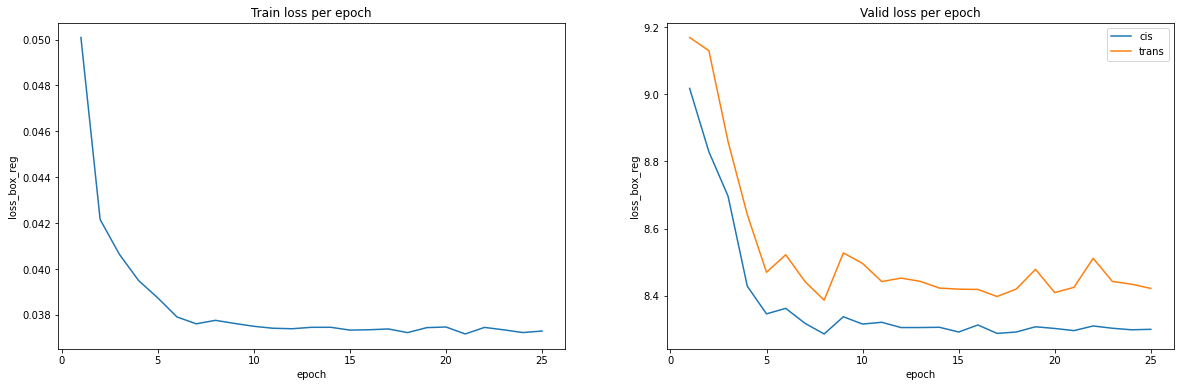

In [34]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

#### Save the figure to pdf format in the figures folder

In [35]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Make Predictions with a model

### Load 10 random predictions

In [ ]:
# Loads 10 images and makes the model do predictions on these images
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

In [ ]:
# Prints 10 images with the predictions before and after NMS
# TODO: faire des méthodes pour simplifier le code
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.05 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

In [ ]:
trans_val_ann['images'][train_labels[3]['image_id']]

In [ ]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 3 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(train_labels[image_i]['boxes'])):
    rect = patches.Rectangle((train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][1]), 
                            train_labels[image_i]['boxes'][i][2]-train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][3]-train_labels[image_i]['boxes'][i][1], 
                            linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [ ]:
boxes_to_keep

In [ ]:
pred[image_i]['boxes'][0]

In [ ]:
train_labels[image_i]['boxes']

# Evalutate on COCO detection metrics

### Test on COCO metrics from data loaders
##### 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [36]:
# takes +- 25min to run on cis_test
cis_coco_evaluator = evaluate(cis_test_dataloader, cis_coco)

Accumulating evaluation results...
DONE (t=1.82s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.783
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [37]:
# takes +- 25min to run on cis_test
trans_coco_evaluator = evaluate(trans_test_dataloader, trans_coco)

Accumulating evaluation results...
DONE (t=3.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [39]:
print('cis test 25 epochs roi online augmentation')
print('_'*80)
cis_coco_evaluator.summarize()

cis test 25 epochs roi online augmentation
________________________________________________________________________________
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.783
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m

In [40]:
print('trans test 25 epochs roi online augmentation')
print('_'*80)
trans_coco_evaluator.summarize()

trans test 25 epochs roi online augmentation
________________________________________________________________________________
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium |

# Methods

## Method 3 (Subspace alignment based Domain adaptation)

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

Papers 

 1. https://arxiv.org/pdf/1507.05578.pdf

 2.  https://openaccess.thecvf.com/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf

**Construct source matrix:** 

We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, it has to have a IoU > thres_IoU with the ground truth of the given image. 

In [ ]:
# 20 minutes
thres_IoU = 0.50
count = 0

X_source = torch.tensor([])
bbox_idx = torch.arange(1000)

model.eval()

for images, targets in train_dataloader: 
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count += 1

    if count%100 == 0:
        print(count)

    with torch.no_grad():
        outputs = []
        hook = model.rpn.register_forward_hook(
        lambda self, input, output: outputs.append(output))

        outputs1 = []
        hook1 = model.roi_heads.box_head.register_forward_hook(
        lambda self, input, output: outputs1.append(output))

        res = model(images)
        hook.remove()
        hook1.remove()

    coords = outputs[0][0][0].cpu() # [1000,4]
    feat = outputs1[0].cpu() # [1000, 1024]

    gt = targets[0]['boxes'].cpu()

    bbox_idx_to_keep = torch.tensor([])
    for i in range(gt.shape[0]):

        IoUs = bops.box_iou(gt[i].reshape(1,4), coords)
        IoUs = IoUs.reshape(1000)
        bbox_idx_to_keep = torch.cat((bbox_idx_to_keep, bbox_idx[IoUs >= thres_IoU]),dim=0)

    X_source = torch.cat((X_source,feat[torch.unique(bbox_idx_to_keep).long()]), dim=0)

In [ ]:
X_source.shape

### Save 1

In [ ]:
torch.save(X_source, 'saved_data/X_source_05_50_rpn_roi_1_100.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)

In [ ]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca = PCA(n_components=100)
pca.fit(X_source_scaled)

X_source_proj = pca.components_
X_source_proj = torch.from_numpy(X_source_proj)


In [ ]:
X_source_proj.shape

In [ ]:
plt.plot(pca.explained_variance_ratio_) 
plt.grid()

### Save 2

In [ ]:
torch.save(X_source_proj, 'saved_data/X_source_proj_05_50_rpn_roi_1_100.pt')

### Target data with batch size 1

In [ ]:
# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

 **Construct target matrix:** 
 
We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes
 extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, the predicted bbox associated with the feature has to have a confidence score > thres_conf_score (since we don't use target labels we can't use the IoU here).


In [ ]:
# 30 minutes
thres_conf_score= 0.50 
count=0

X_target=torch.tensor([])

model.eval()

for images, targets in trans_test_batch1_dataloader: # trans location valid AND test ?
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():

        outputs = []
        hook = model.backbone.register_forward_hook(
        lambda self, input, output: outputs.append(output))
        res = model(images)
        hook.remove()

        box_features = model.roi_heads.box_roi_pool(outputs[0], [r['boxes'] for r in res], [i.shape[-2:] for i in images])
        box_features = model.roi_heads.box_head(box_features)

    X_target = torch.cat((X_target,box_features[res[0]['scores']>=thres_conf_score].cpu()), dim=0)


In [ ]:
X_target.shape

In [ ]:
torch.save(X_target, 'saved_data/X_target_05_50_rpn_roi_1_100.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_target_scaled = scaler.fit_transform(X_target)

In [ ]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca_proj = PCA(n_components=100)
pca_proj.fit(X_target_scaled)

X_target_proj = pca_proj.components_
X_target_proj = torch.from_numpy(X_target_proj)

In [ ]:
plt.plot(pca_proj.explained_variance_ratio_) # we keep 100 dimensions
plt.grid()

In [ ]:
X_target_proj.shape

In [ ]:
torch.save(X_target_proj, 'saved_data/X_target_proj_05_50_rpn_roi_1_100.pt')

### Transformation matrix M

𝑀 is obtained by minimizing the following Bregman matrix divergence (following closed-form solution given in the paper)

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) 

In [ ]:
M.shape

### Project source data into target aligned source subspace

In [ ]:
Xa = torch.matmul(X_source_proj.T,M)

In [ ]:
Xa.shape

In [ ]:
# To project a given feature

# feat(1,1024) x Xa (1024,100)

### Projet target data in target subspace

In [ ]:
# To project a given feature

# feat(1,1024) x X_target_proj.T (1024,100)

### Train adapted model

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
# Load because it takes time to generate the following matrices so they are saved
X_source_proj = torch.load('saved_data/X_source_proj_05_50_rpn_roi_1_512.pt')
X_target_proj = torch.load('saved_data/X_target_proj_05_50_rpn_roi_1_512.pt')

In [ ]:
X_source_proj.device

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) # transformation matrix

Xa = torch.matmul(X_source_proj.T,M) # target aligned source subspace

In [ ]:
M.to(device)

In [ ]:
Xa.to(device)

In [ ]:
# class FastRCNNPredictor_custom(nn.Module):
#     """
#     Standard classification + bounding box regression layers
#     for Fast R-CNN.

#     Args:
#         in_channels (int): number of input channels
#         num_classes (int): number of output classes (including background)
#     """

#     def __init__(self, in_channels, num_classes, m_transfo):
#         super(FastRCNNPredictor_custom, self).__init__()
#         self.cls_score = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes))
#         self.bbox_pred = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes * 4))
#         self.cls_score[0].weight= nn.Parameter(m_transfo, requires_grad = False)
#         self.bbox_pred[0].weight= nn.Parameter(m_transfo, requires_grad = False)

#     def forward(self, x):
#         if x.dim() == 4:
#             assert list(x.shape[2:]) == [1, 1]
#         x = x.flatten(start_dim=1)
#         scores = self.cls_score(x)
#         bbox_deltas = self.bbox_pred(x)

#         return scores, bbox_deltas


In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_model.pt'))

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# weights to learn
for i in range(4):
    print(params[i].shape)

In [ ]:
# Nb of weights in the optimizer
for i in range(len(optimizer.param_groups[0]['params'])):
    print(optimizer.param_groups[0]['params'][i].shape)

## Before training

In [ ]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

In [ ]:
last_train_logs = all_train_logs
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [ ]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Evaluate the new model

In [ ]:
# takes +- 15min to run on cis_test
cis_coco_evaluator_method = evaluate(cis_test_dataloader, cis_coco)

In [ ]:
# trans with method 3
model.roi_heads.box_predictor.cls_score[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False) 
model.roi_heads.box_predictor.bbox_pred[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False)
model.to(device)

In [ ]:
# takes +- 15min to run on cis_test
trans_coco_evaluator_method = evaluate(trans_test_dataloader, trans_coco)

In [ ]:
print('cis test 50 epochs rpn+roi, method3.2 with 25 epochs & d=512')
print('_'*80)
cis_coco_evaluator_method.summarize()

In [ ]:
print('trans test 50 epochs rpn+roi, method3.2 with 25 epochs & d=512')
print('_'*80)
trans_coco_evaluator_method.summarize()

### Load a model with Method 3.2

In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_scheduler.pt'))